In [20]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

Loading the data sets

In [21]:
dataset = pandas.read_csv('layers3.csv')
contamination = pandas.read_csv('contamination.csv')
# only take the data where the run = 0
dataset = dataset[dataset['run'] == 0]
print(dataset.head())
print(dataset.columns)
dataset_run2 = pandas.read_csv('layers2.csv')
# only take the data where the run = 1
dataset_run2 = dataset_run2[dataset_run2['run'] == 1]


   run  layers  atempt                                         train_loss  \
0    0       1       0  [[3.2475214595794677, 3.144815221786499, 3.115...   
1    0       1       1  [[3.2748614456653593, 3.2048209629058837, 3.15...   
2    0       1       2  [[3.257897061109543, 3.134585788488388, 3.1015...   
3    0       1       3  [[3.272159205675125, 3.1576671998500823, 3.092...   
4    0       1       4  [[3.2696512084007265, 3.1786662497520446, 3.10...   

                           validation_loss   generalisation_x2  \
0  [3.013313335232922, 3.0036669710633634]  (0.0002, 0.0, 0.0)   
1  [3.0030739968372004, 2.997658109414689]     (0.0, 0.0, 0.0)   
2  [3.001769375804138, 2.9945979657558266]  (0.0003, 0.0, 0.0)   
3  [2.9992536131374115, 2.989867365285497]  (0.0002, 0.0, 0.0)   
4   [3.005827977076606, 3.001012933676883]     (0.0, 0.0, 0.0)   

          generalisation_x3 generalisation_x4  
0  (0.9775, 0.9654, 0.0481)   (0.0, 0.0, 0.0)  
1  (0.9853, 0.8336, 0.0444)   (0.0, 0.0, 0.0

Creating functions to plot the data 

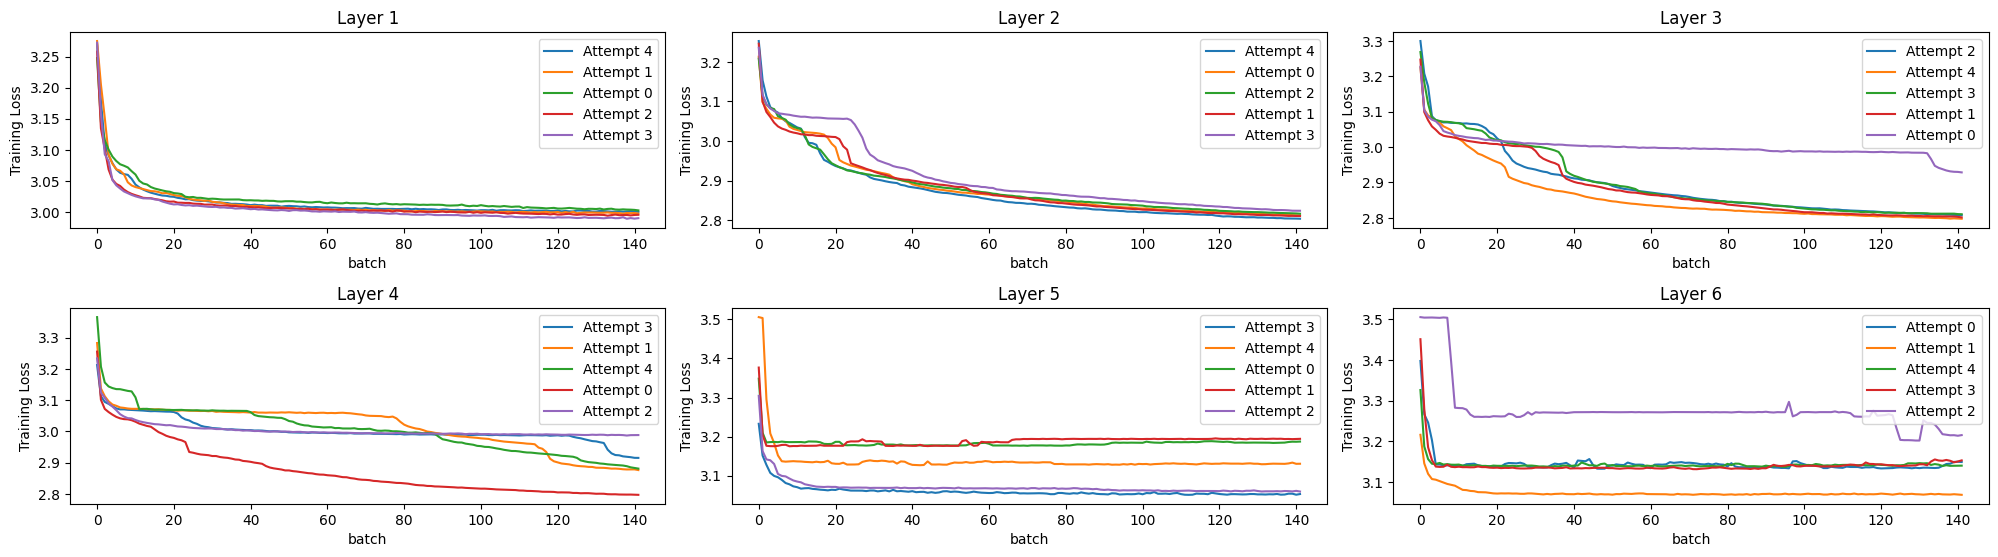

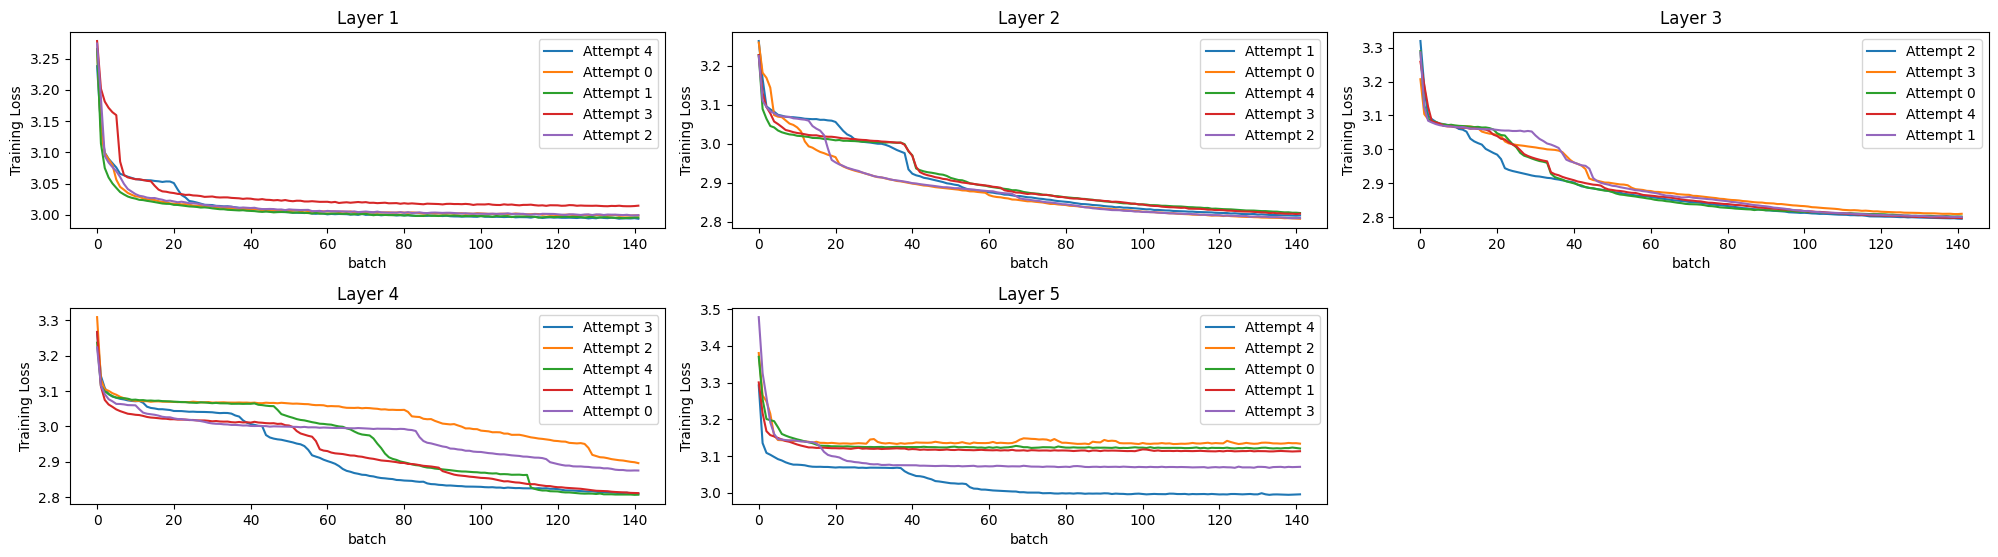

In [29]:
def plot_train_loss_by_layer(dataset):
    # Process training loss data
    dataset =dataset.copy()
    dataset.reset_index(drop=True, inplace=True)
    training_loss = dataset['train_loss']
    for i in range(len(training_loss)):
        training_loss[i] = training_loss[i].replace('[','').replace(']','').split(',')
        training_loss[i] = [float(x) for x in training_loss[i]]

    # Create list of layer, attempt, and loss data
    layer_attempt_pairs = []
    for i in range(len(training_loss)):
        layer = dataset['layers'][i]
        attempt = dataset['atempt'][i]
        training_loss_tuple = tuple(training_loss[i])
        layer_attempt_pairs.append((layer, attempt, training_loss_tuple))

    layer_attempt_pairs = list(set(layer_attempt_pairs))
    unique_layers = sorted(dataset['layers'].unique())

    # Setup subplots in 2 rows, 5 columns
    fig, axes = plt.subplots(3, 3, figsize=(20, 8))
    axes = axes.flatten()  # flatten 2D axes array to 1D for easier indexing

    for layer, attempt, losses in layer_attempt_pairs:
        layer_idx = unique_layers.index(layer)
        axes[layer_idx].plot(list(losses), label=f'Attempt {attempt}')

    for idx, (ax, layer) in enumerate(zip(axes, unique_layers)):
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('batch')
        ax.set_ylabel('Training Loss')
        ax.legend()

    # Hide any unused subplots (in case there are fewer than 10 layers)
    for idx in range(len(unique_layers), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


plot_train_loss_by_layer(dataset)
plot_train_loss_by_layer(dataset_run2)

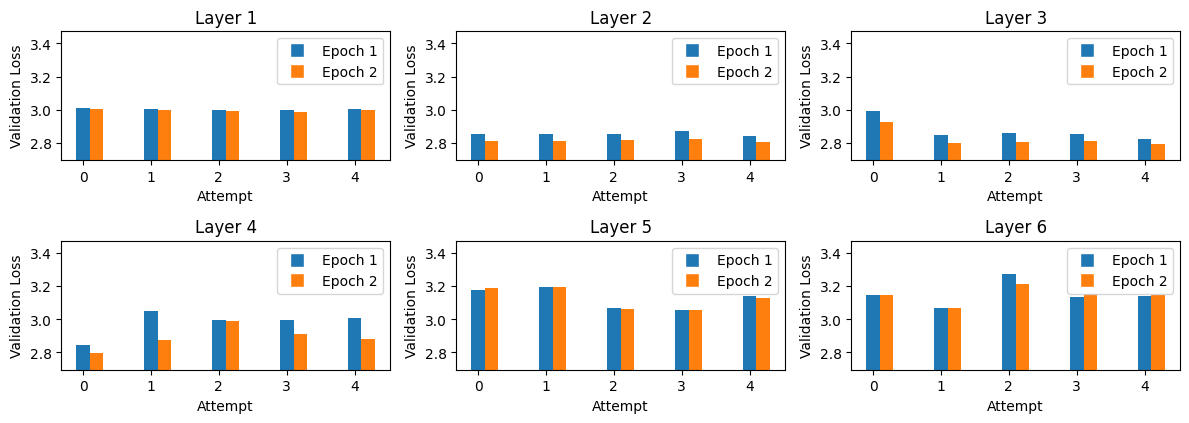

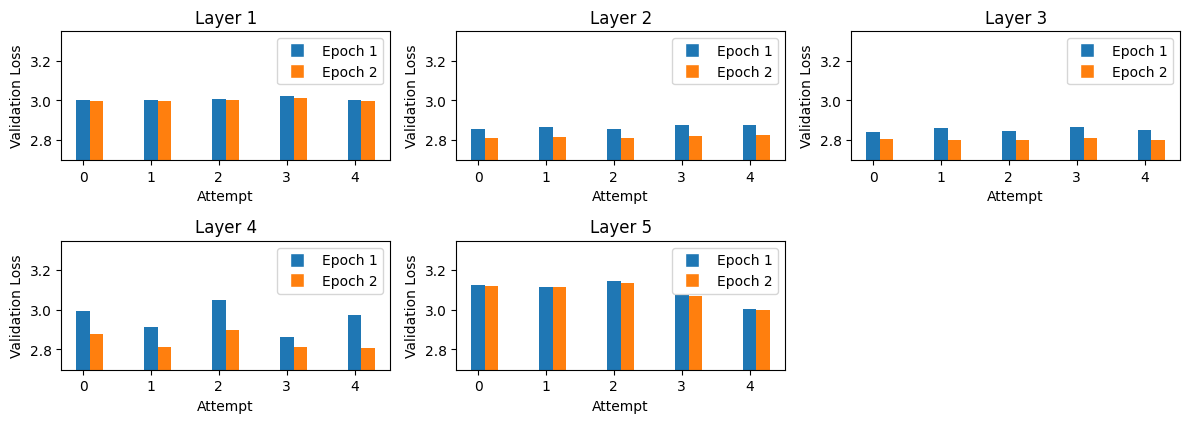

In [28]:
def bar_plot_validation_loss(dataset):
    # Copy and reset index
    dataset = dataset.copy()
    dataset.reset_index(drop=True, inplace=True)

    # Process validation loss as list of floats
    validation_losses = []
    max_loss = float('-inf')
    min_loss = float('inf')
    for val in dataset['validation_loss']:
        losses = [float(x.strip()) for x in val.strip('[]').split(',')]
        validation_losses.append(losses)
        max_loss = max(max_loss, max(losses))
        min_loss = min(min_loss, min(losses))

    # Unique layers
    unique_layers = sorted(dataset['layers'].unique())

    # Define consistent colors for L1, L2, etc.
    color_list = plt.cm.tab10.colors
    max_losses = max(len(losses) for losses in validation_losses)
    loss_colors = {i: color_list[i % len(color_list)] for i in range(max_losses)}

    # Setup subplots with reduced width
    fig, axes = plt.subplots(3, 3, figsize=(12, 6))
    axes = axes.flatten()

    for i, losses in enumerate(validation_losses):
        layer = dataset['layers'][i]
        attempt = dataset['atempt'][i]
        layer_idx = unique_layers.index(layer)
        for j, val_loss in enumerate(losses):
            offset = j * 0.2
            axes[layer_idx].bar(attempt + offset, val_loss, width=0.2, color=loss_colors[j])

    # Add legend once per layer using L1, L2, ...
    legend_handles = [
        plt.Line2D([0], [0], marker='s', color='w', label=f'Epoch {j+1}',
                   markerfacecolor=loss_colors[j], markersize=10)
        for j in range(max_losses)
    ]

    for idx, (ax, layer) in enumerate(zip(axes, unique_layers)):
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('Attempt')
        ax.set_ylabel('Validation Loss')
        ax.set_ylim(min_loss - 0.1, max_loss + 0.2)
        ax.legend(handles=legend_handles)

    # Hide unused subplots
    for idx in range(len(unique_layers), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# Usage
bar_plot_validation_loss(dataset)
bar_plot_validation_loss(dataset_run2)



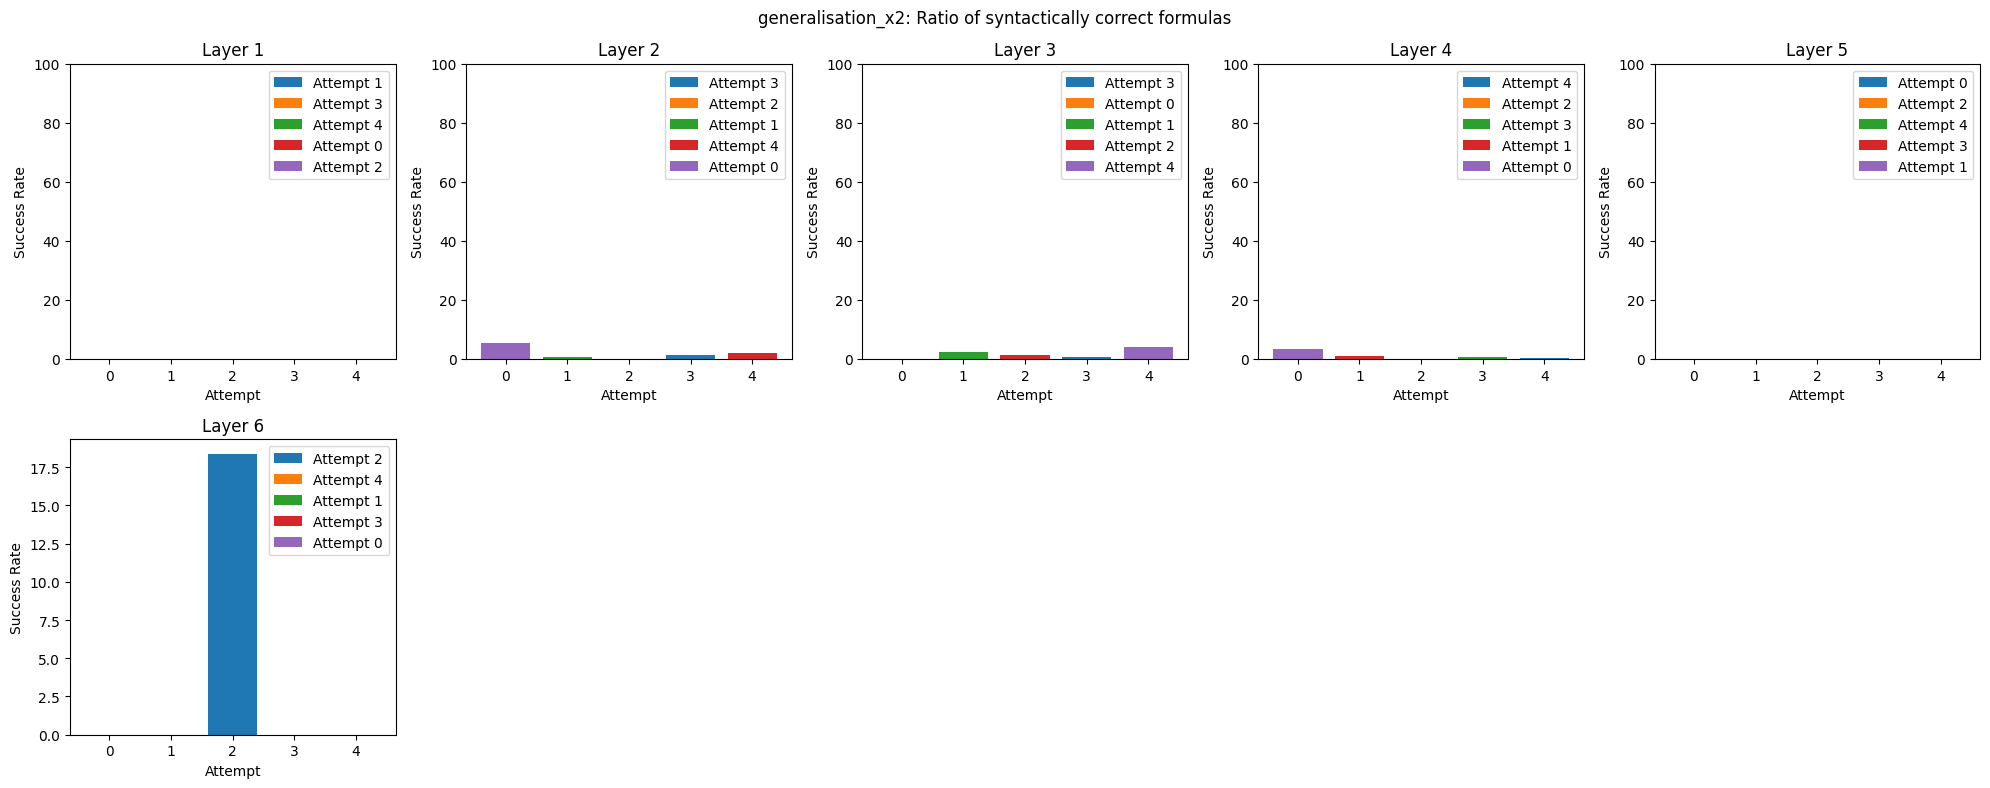

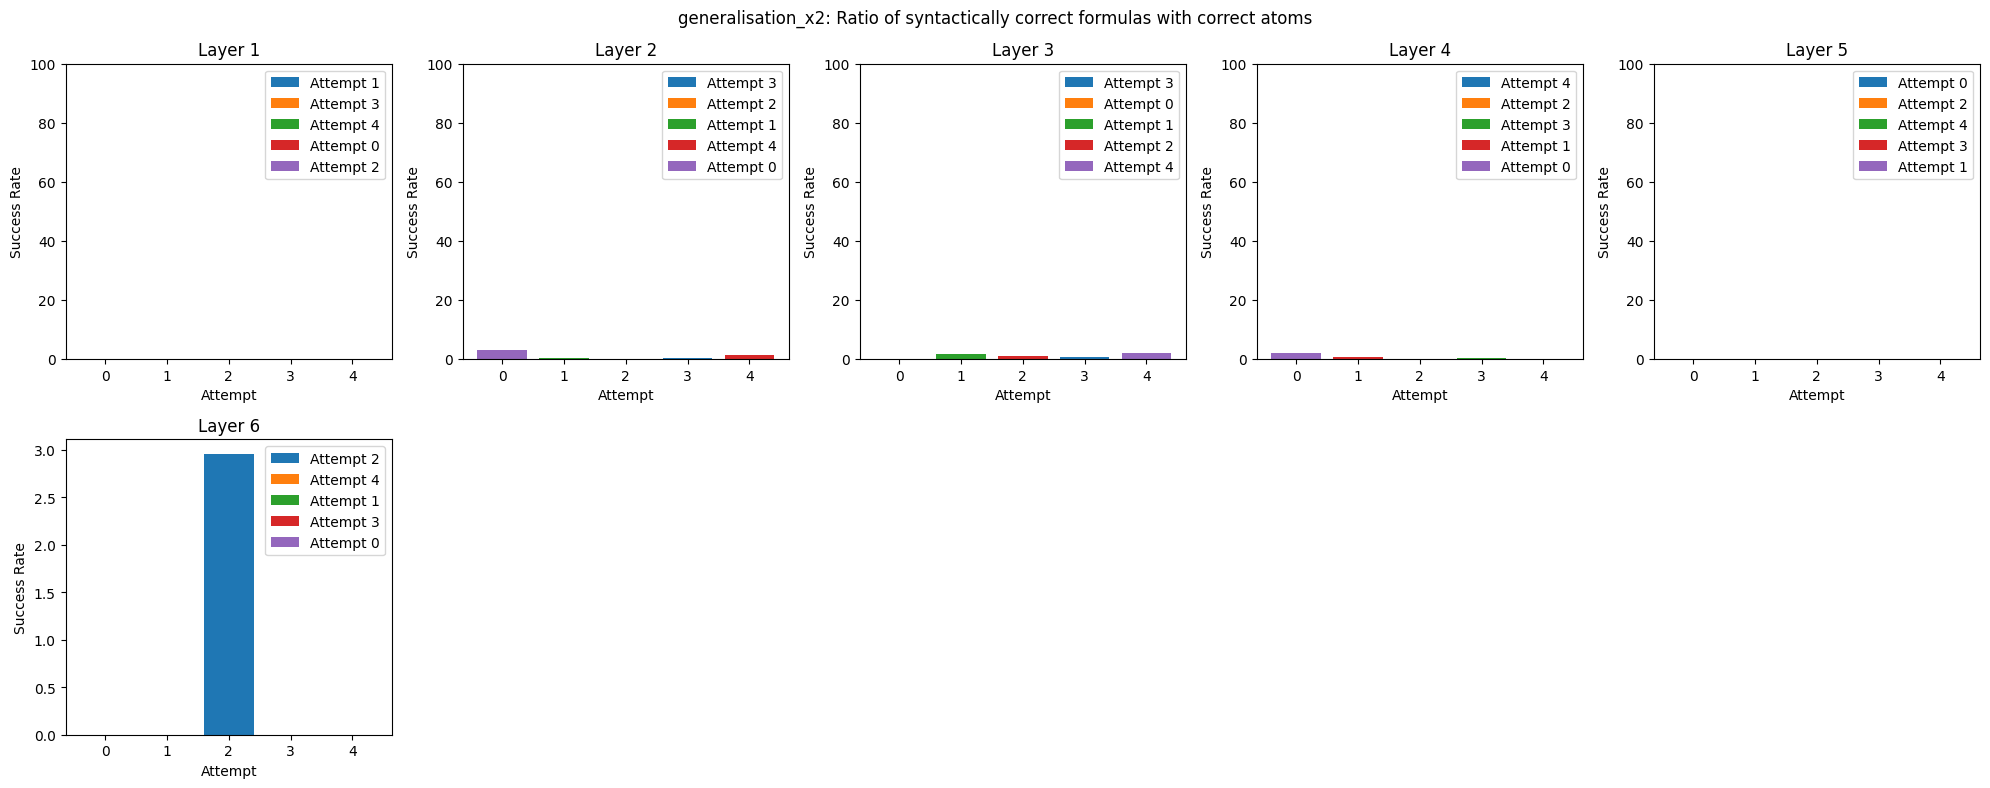

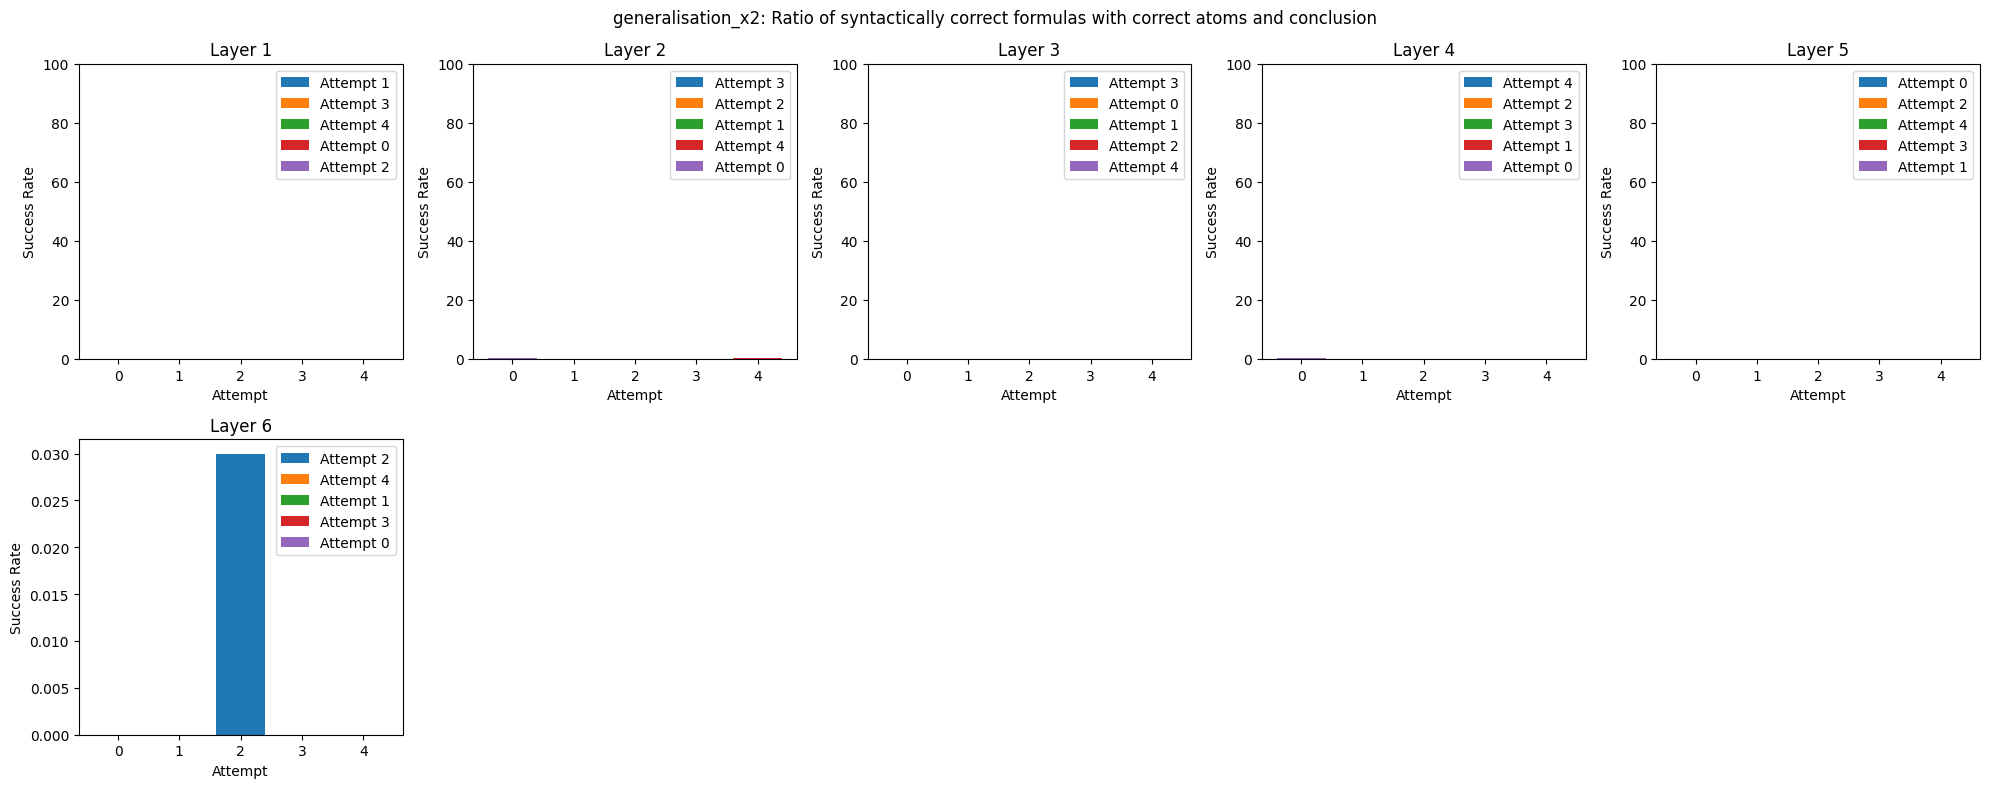

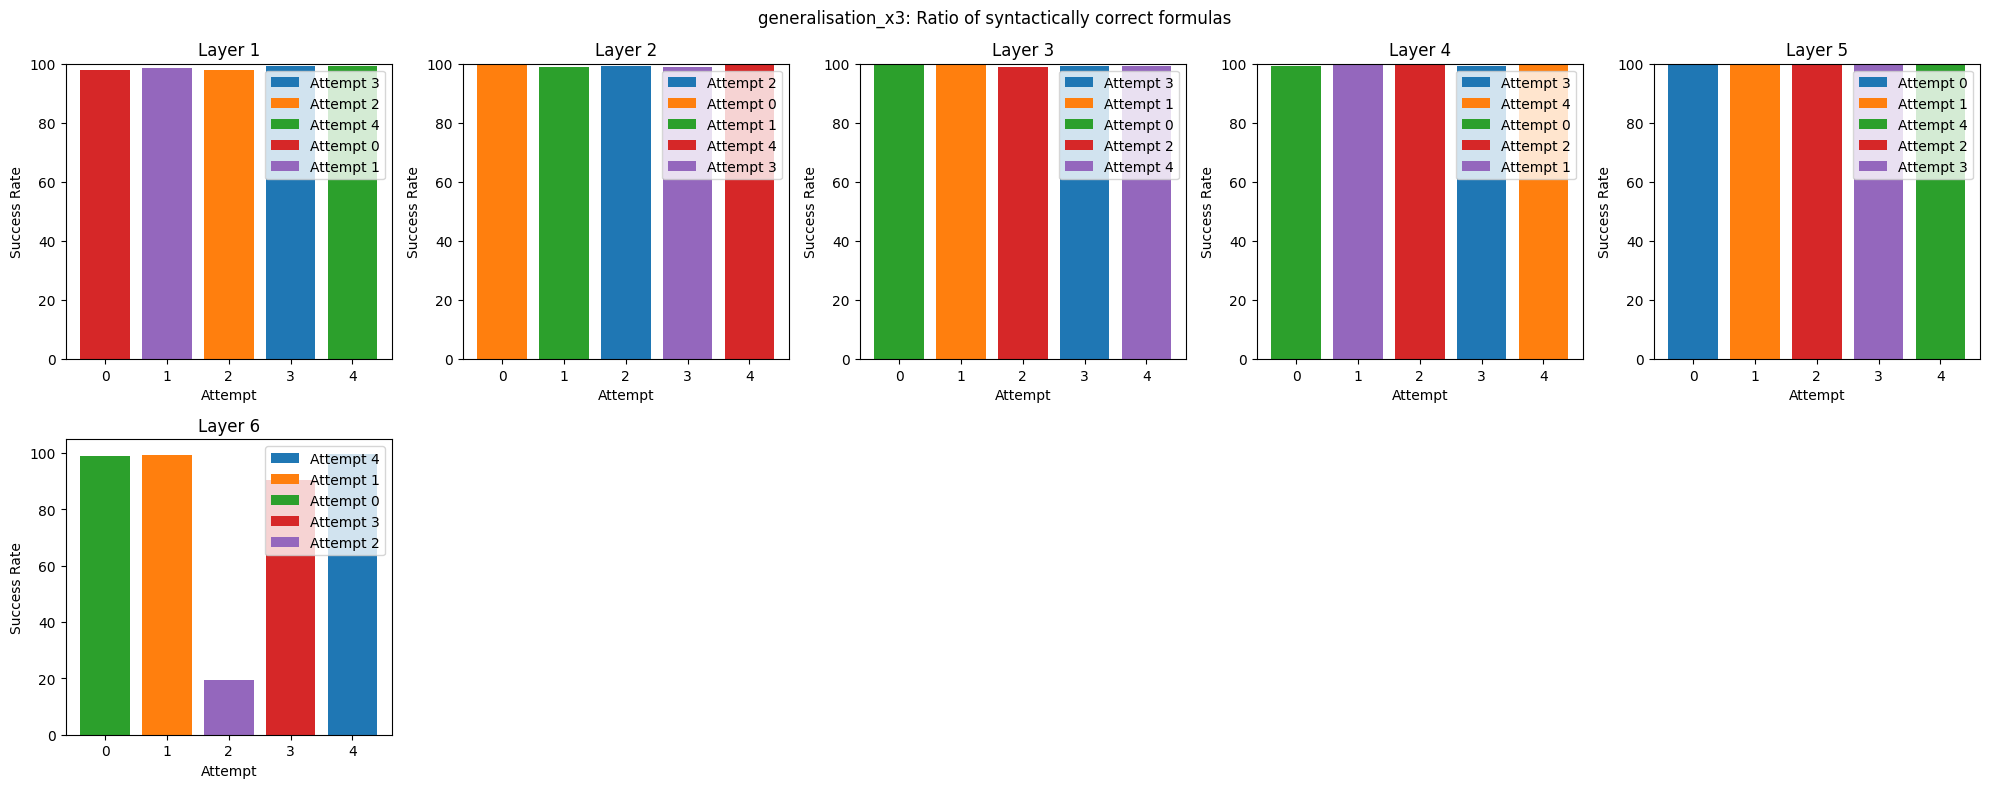

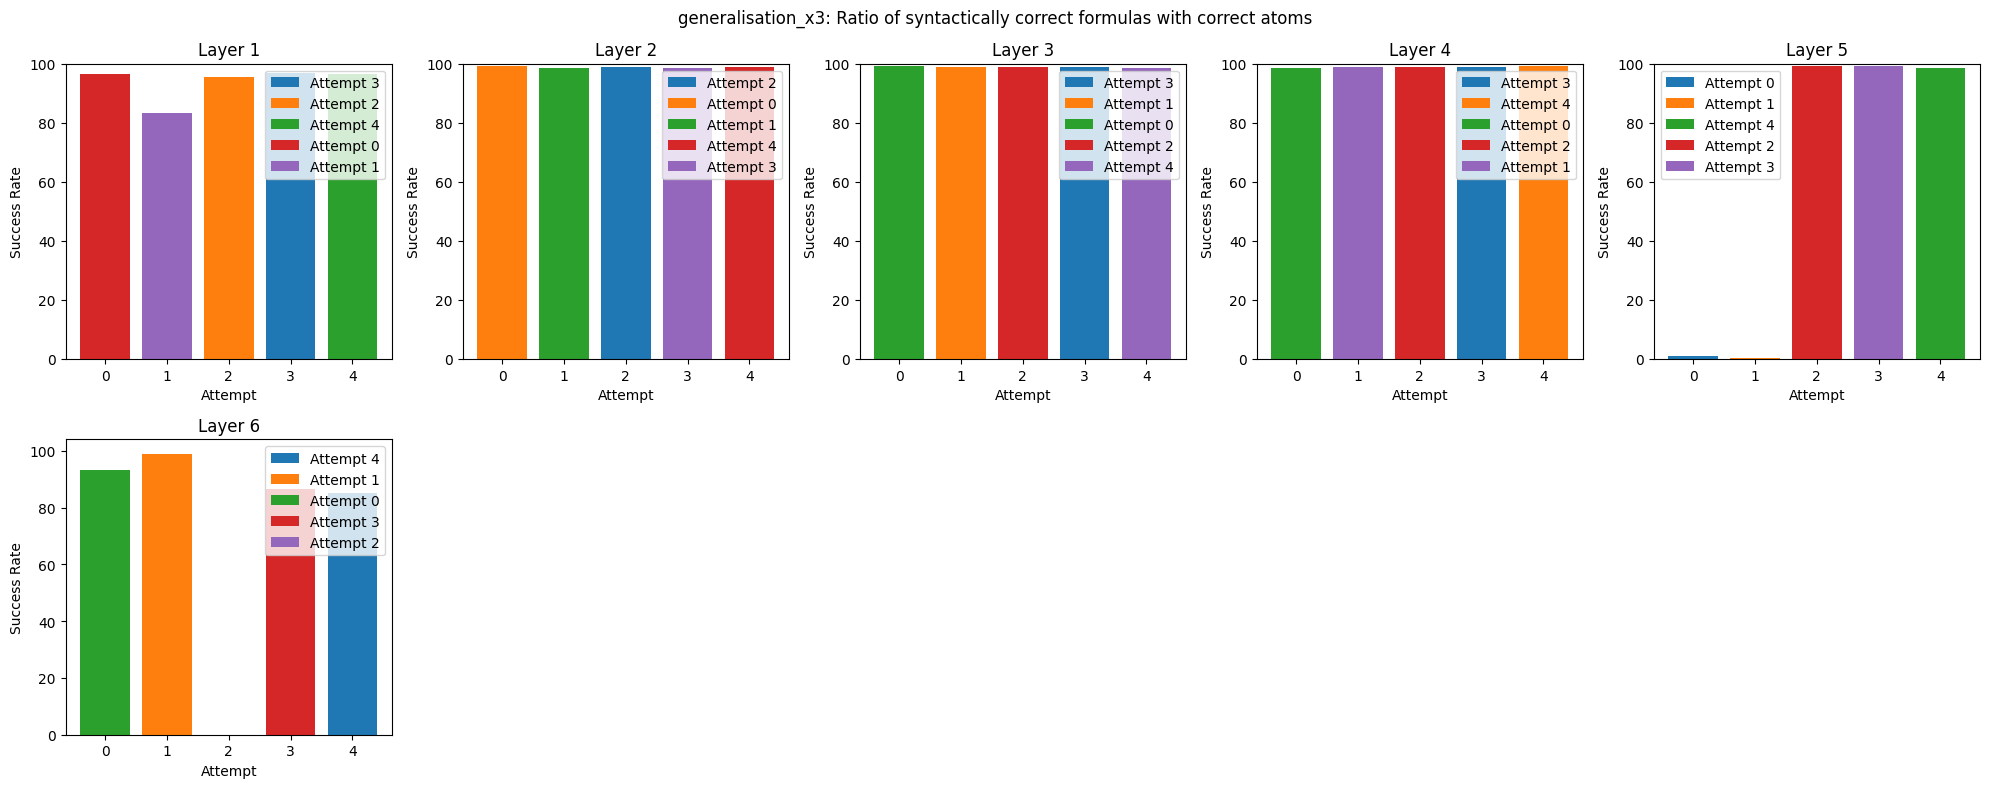

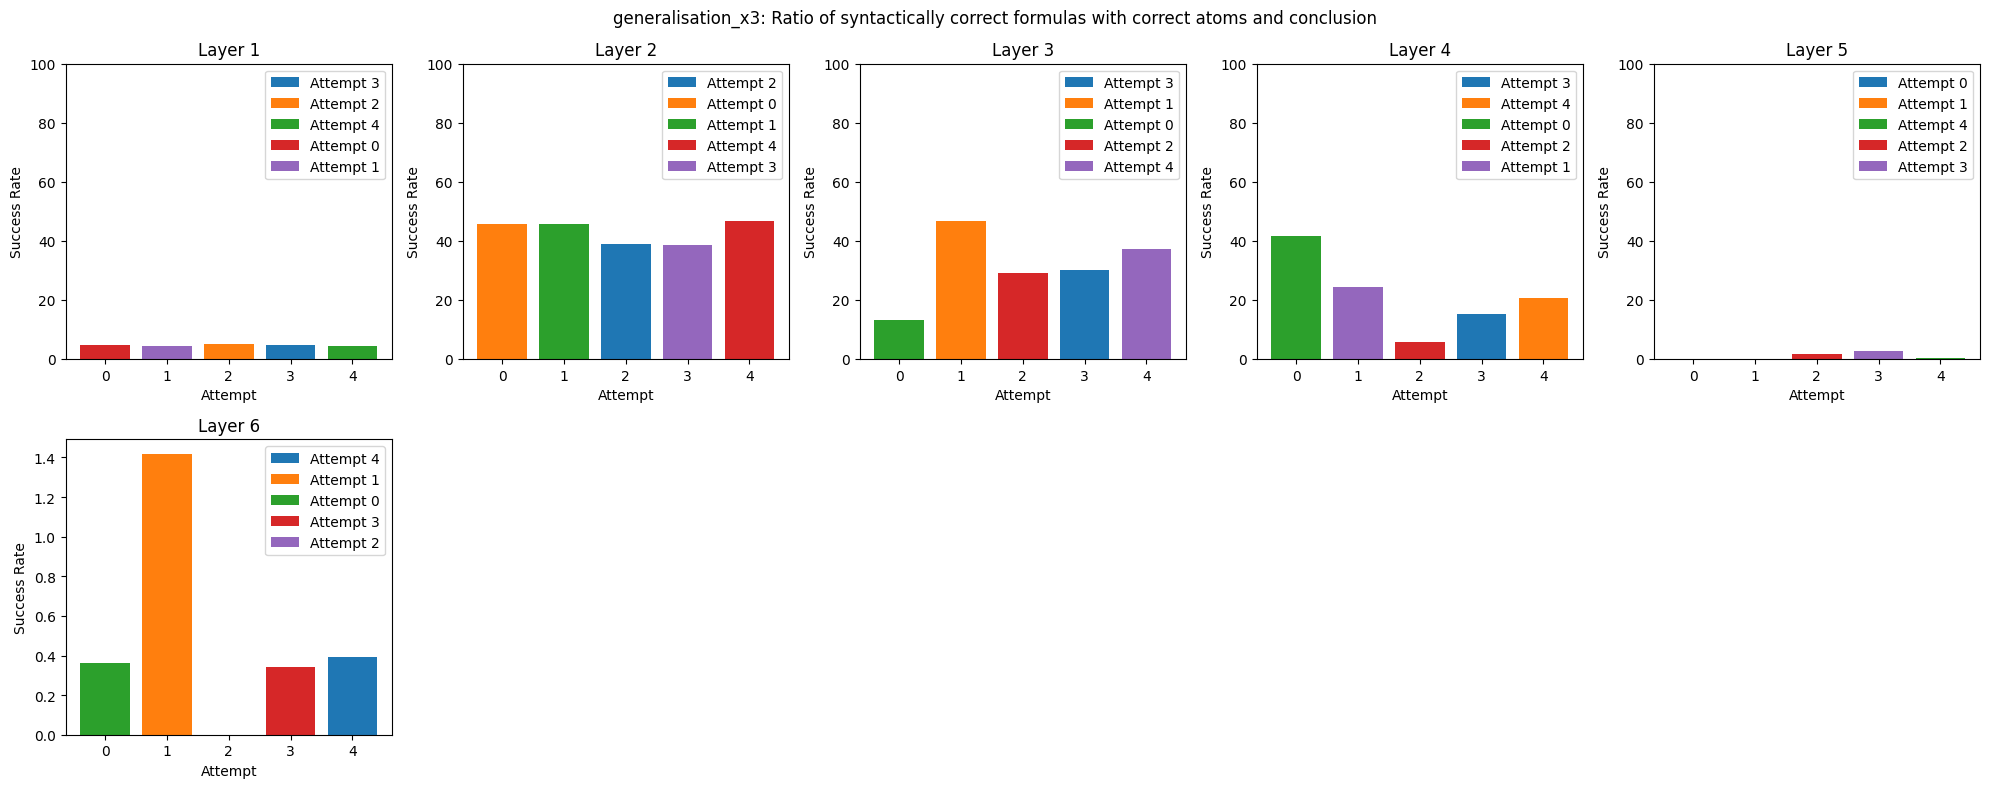

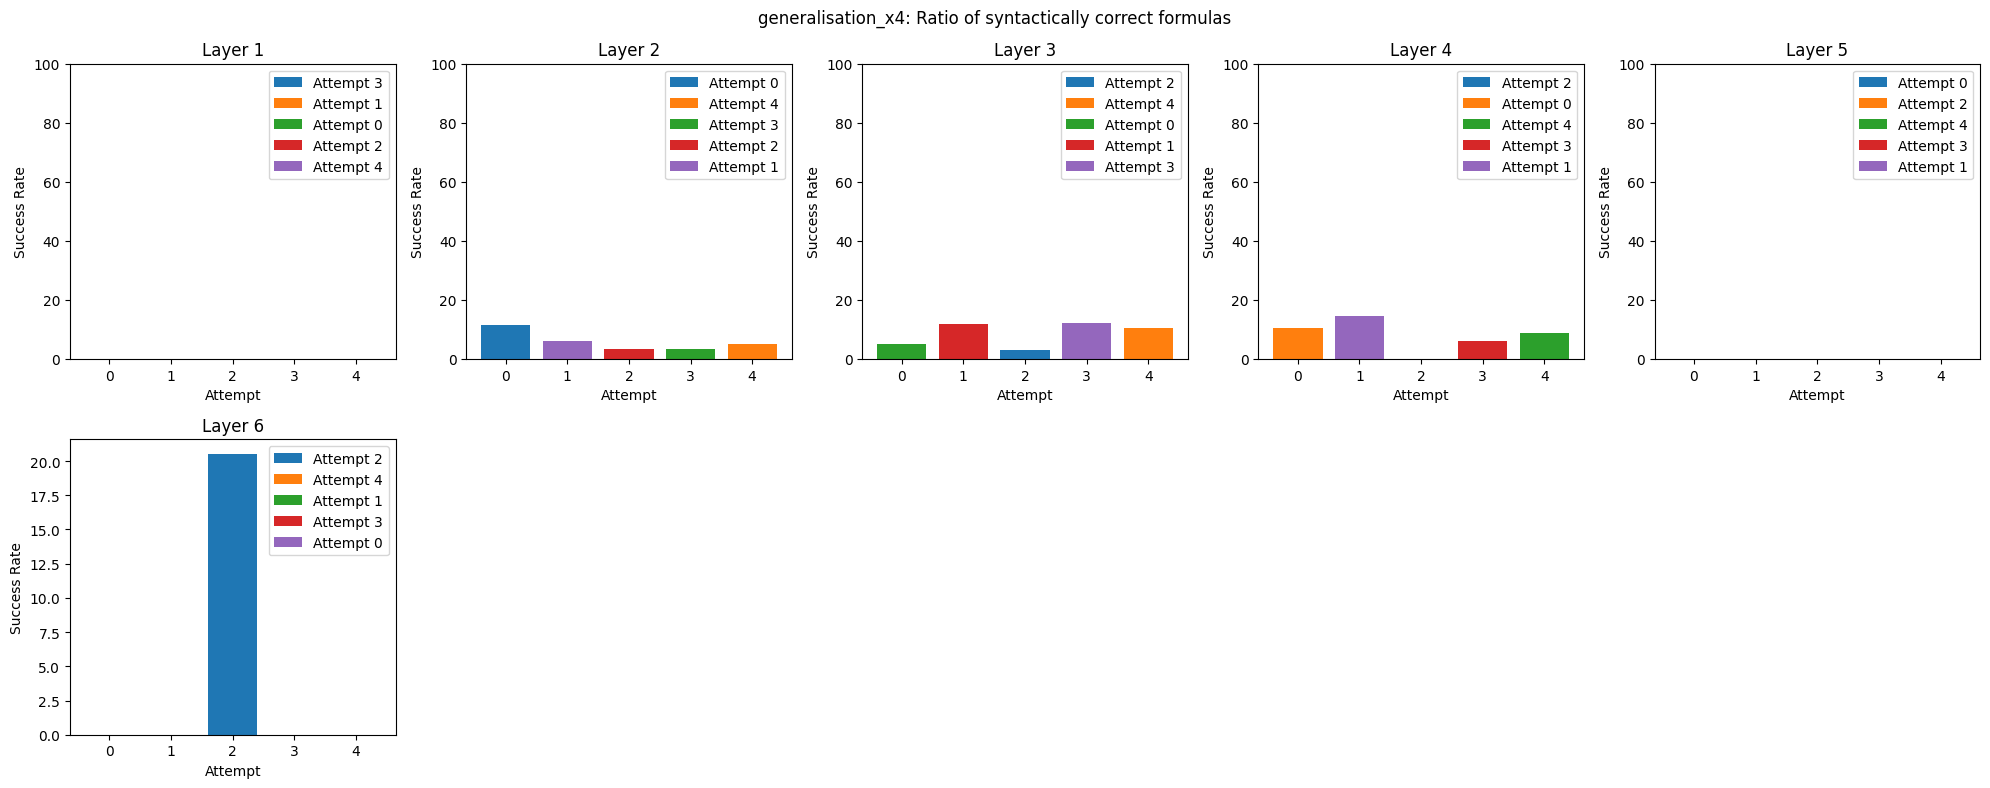

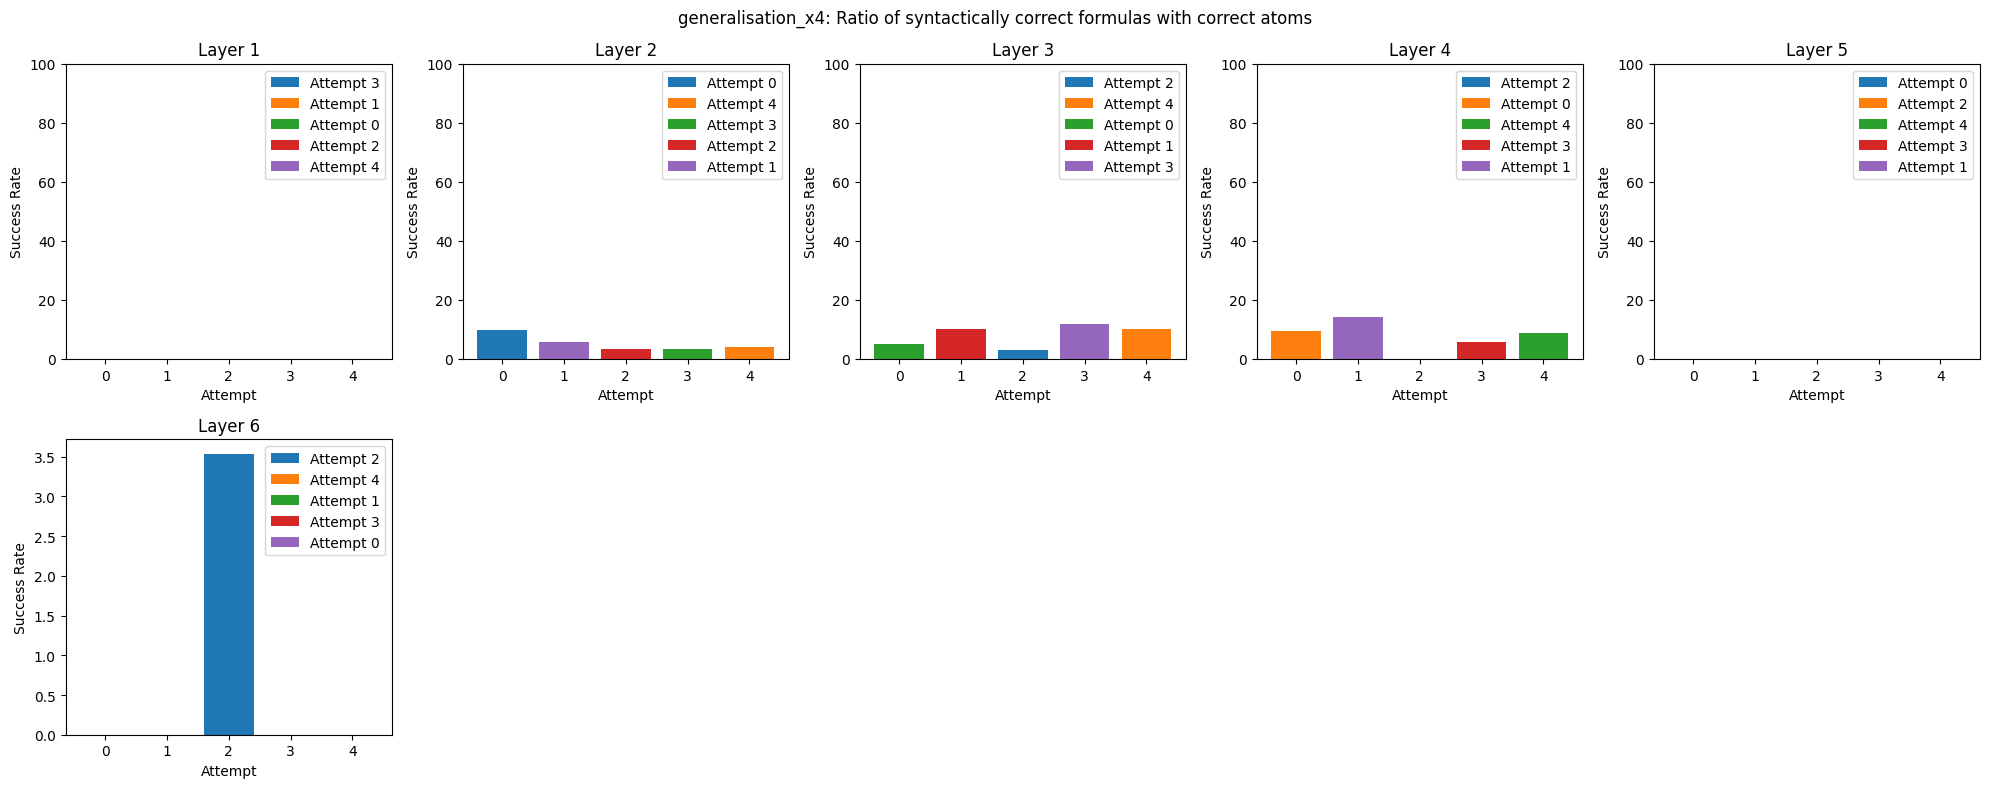

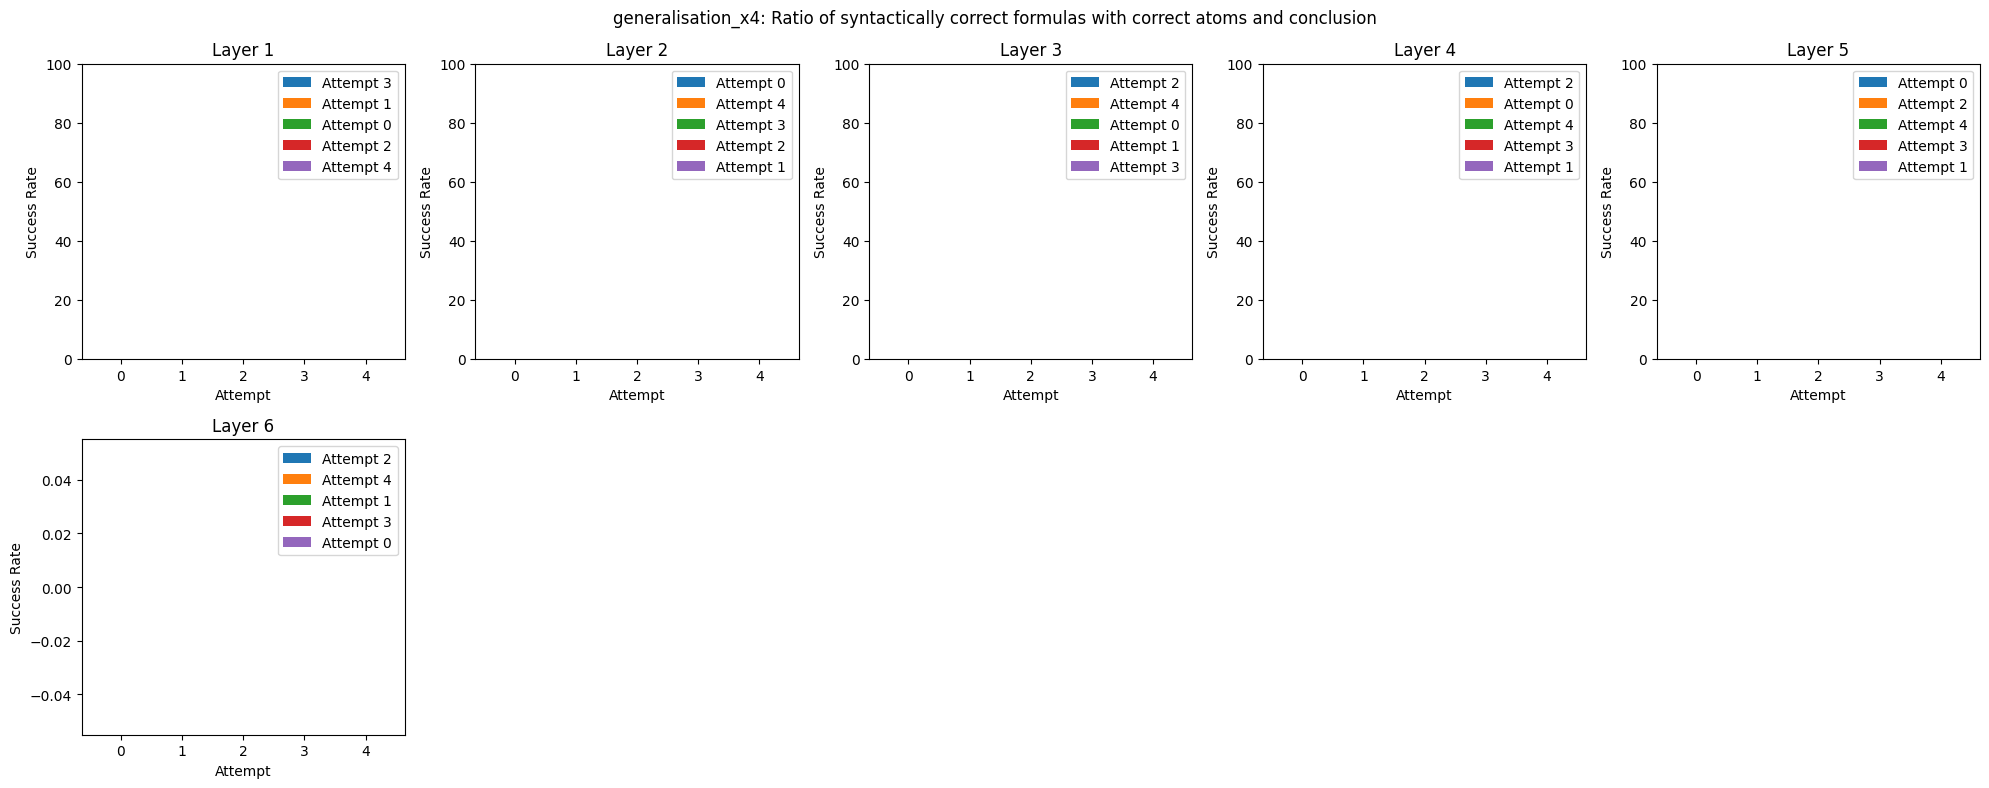

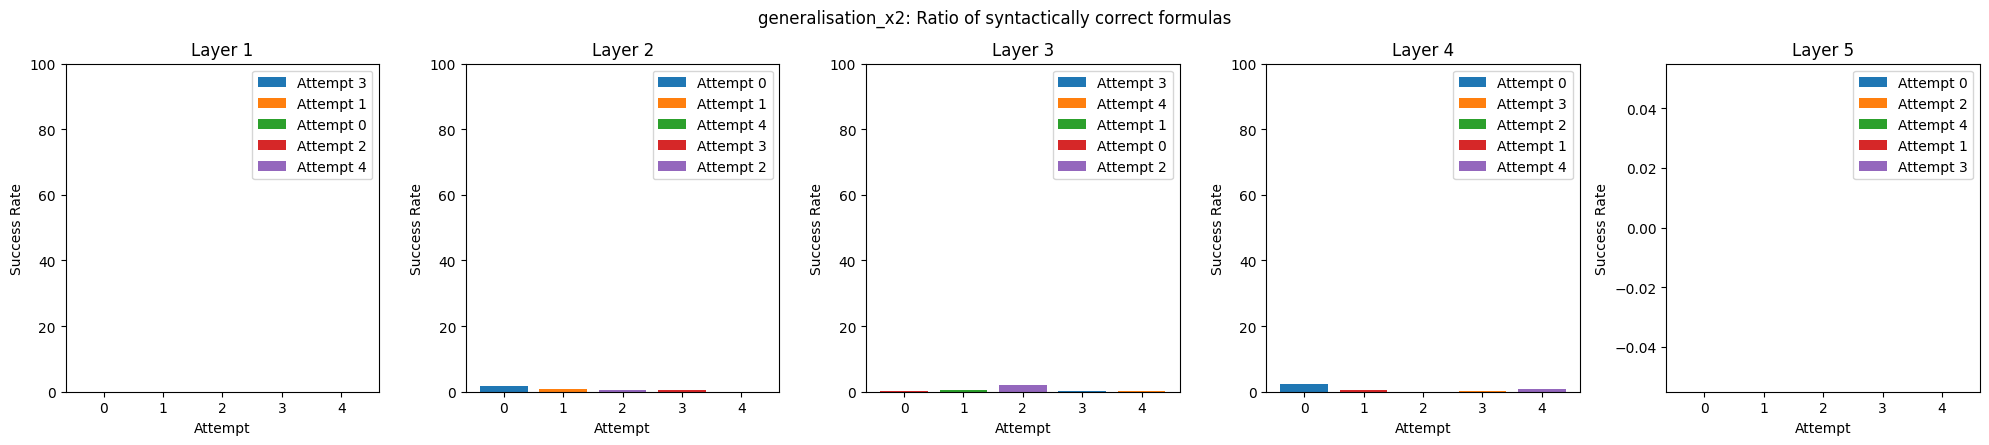

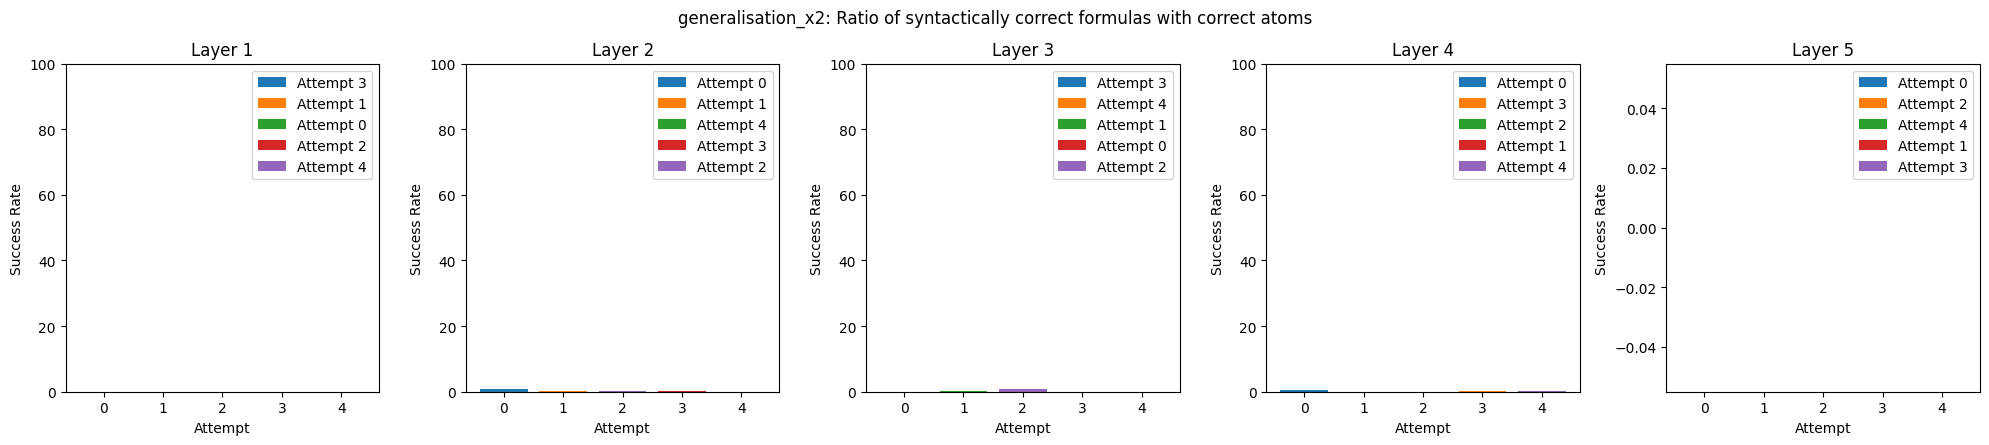

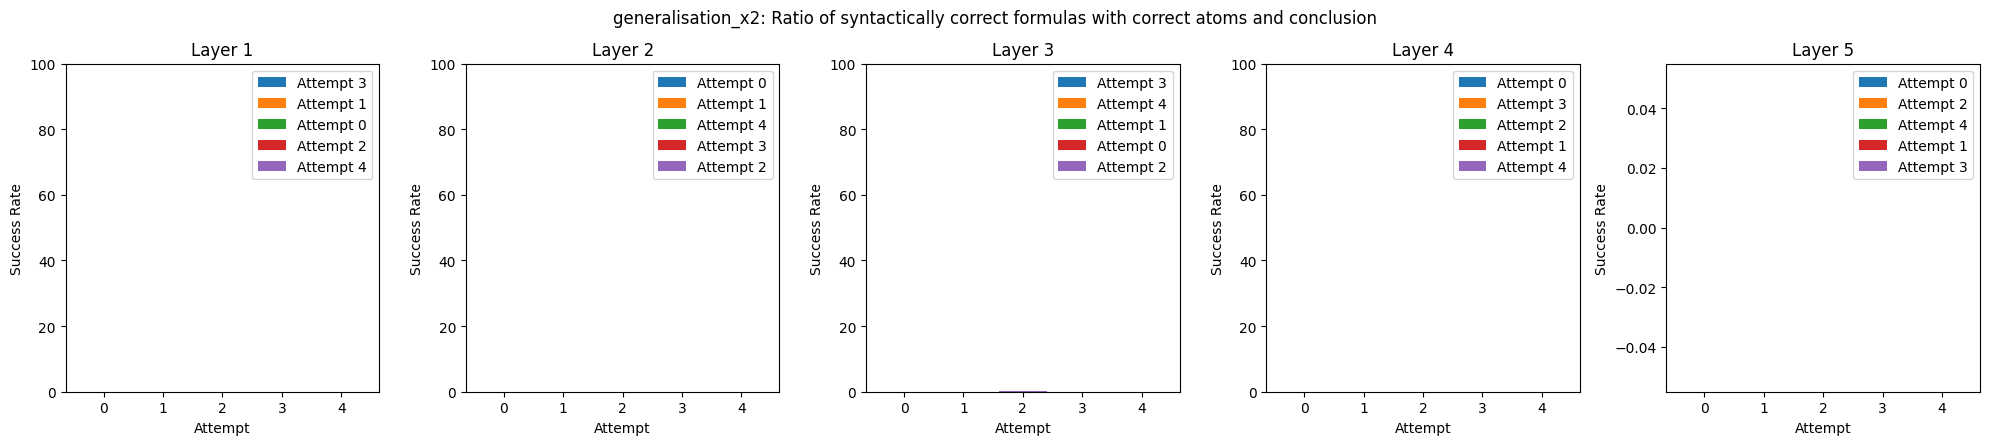

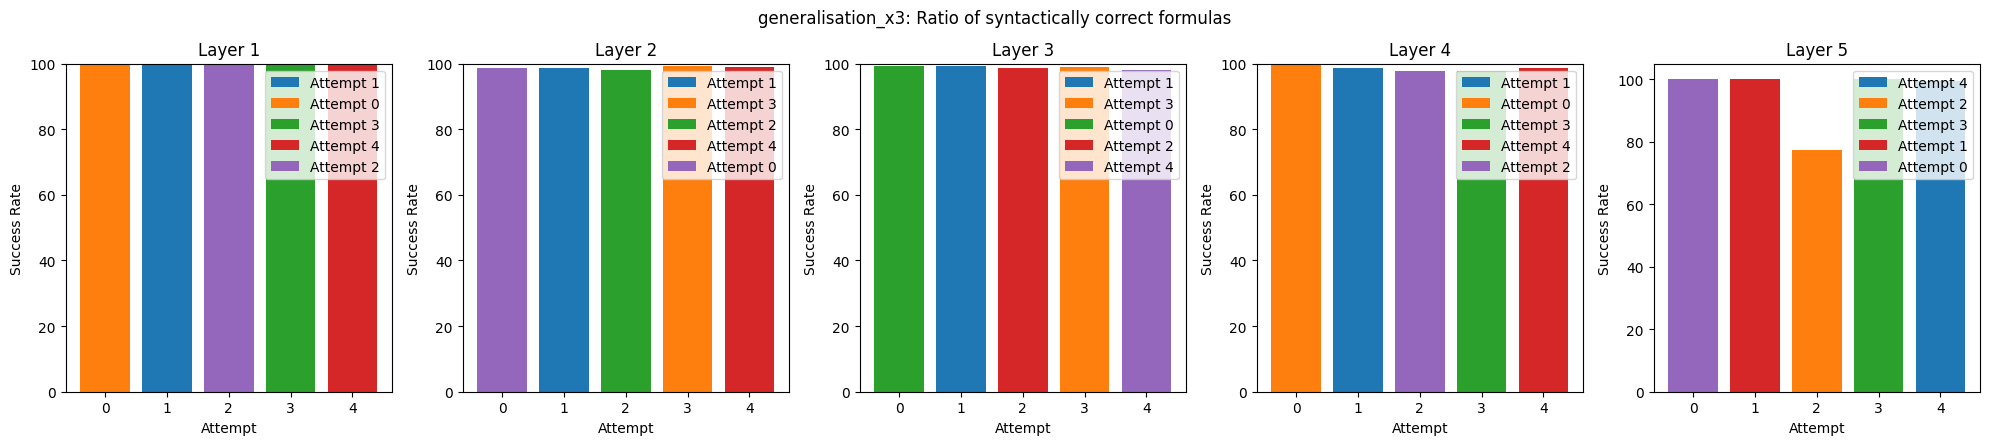

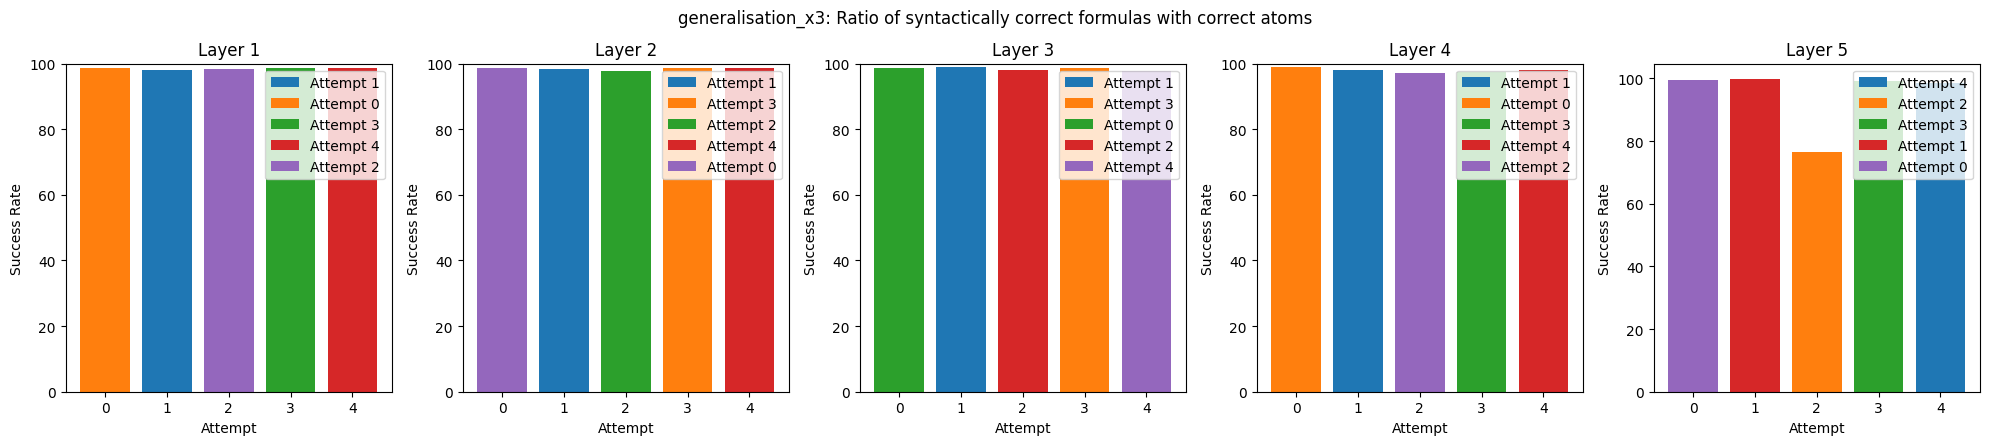

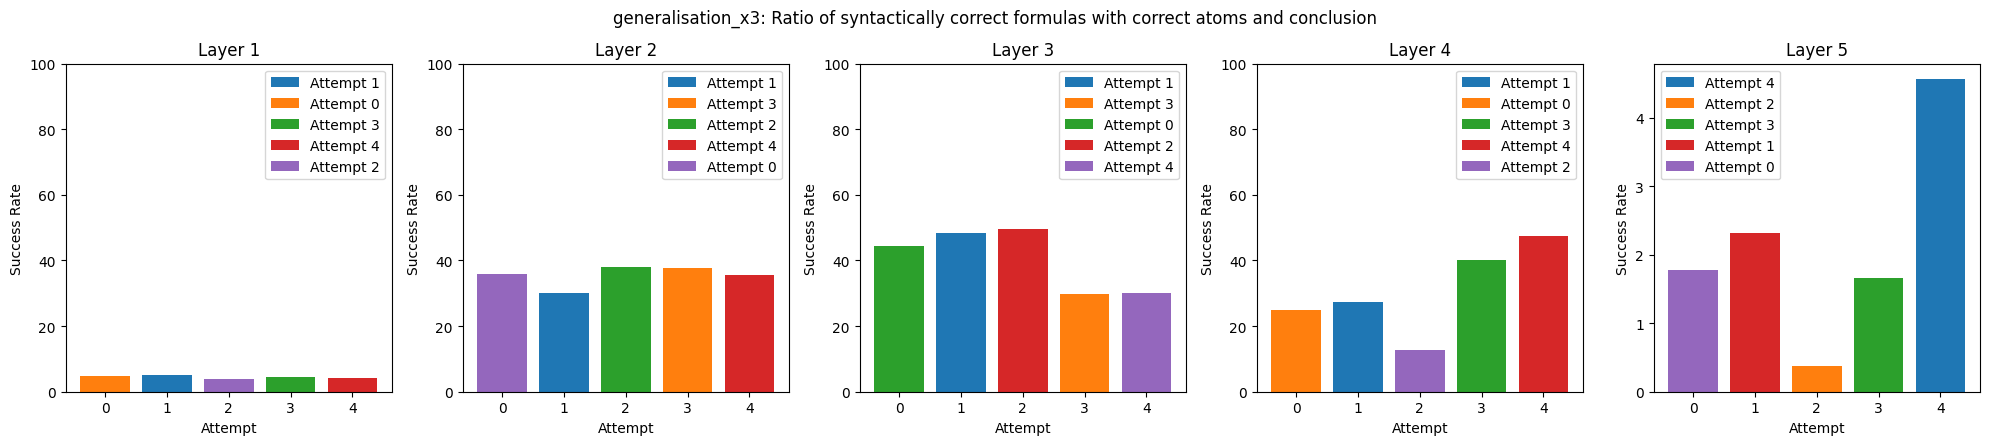

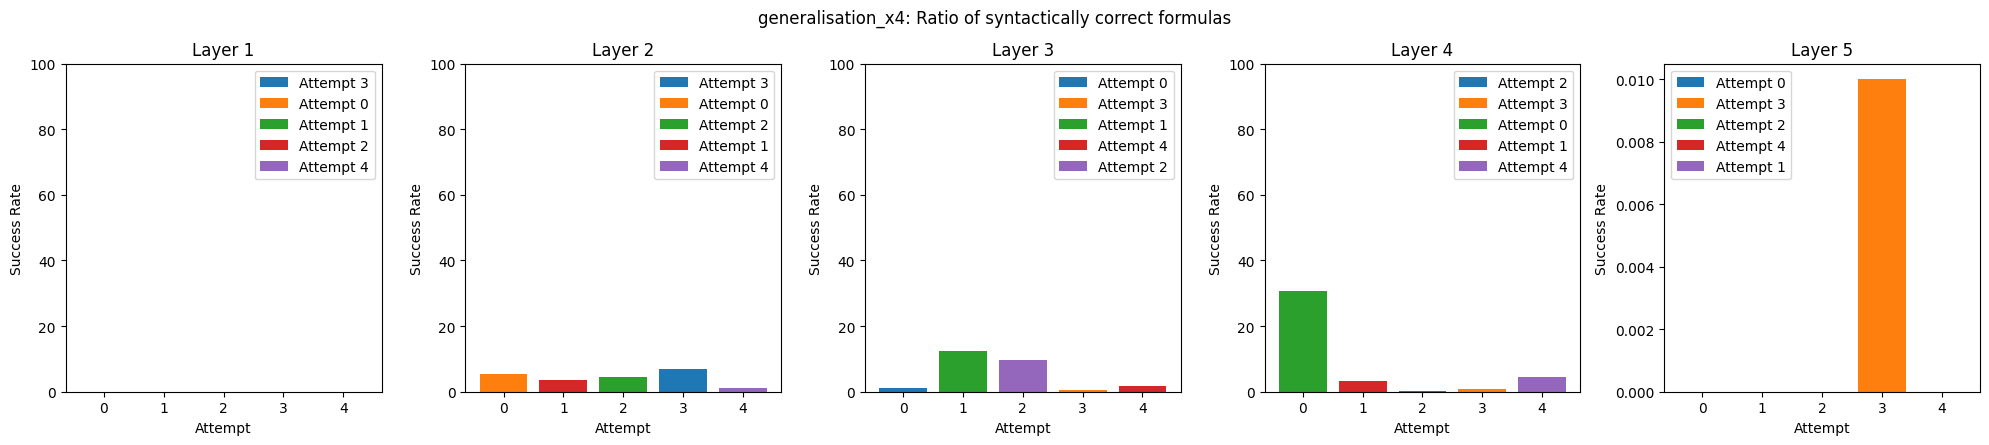

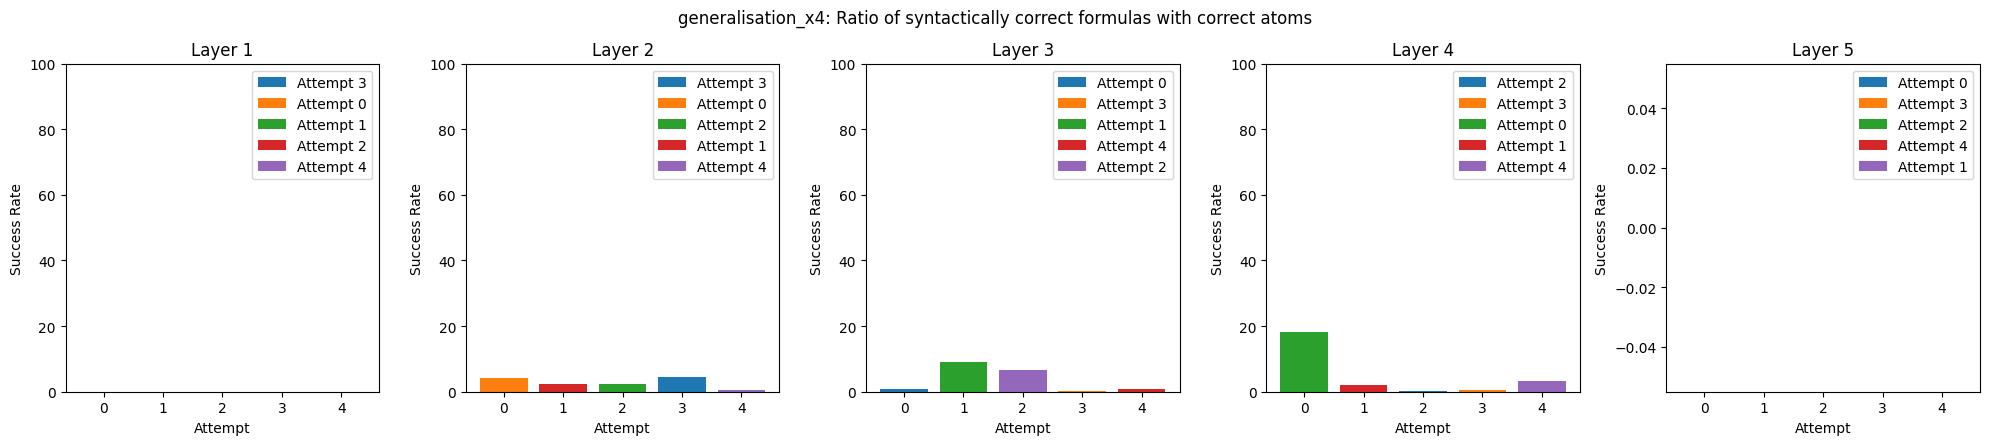

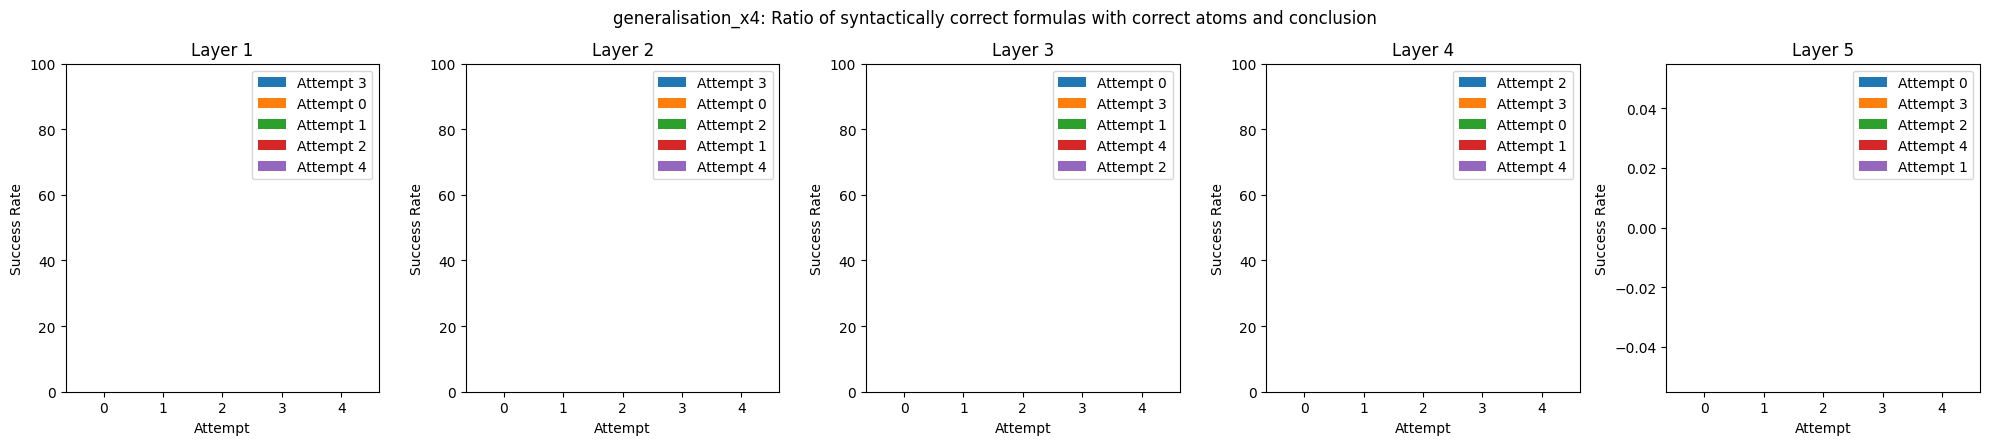

In [25]:
def plot_generalisation(dataset, generalisation_col='generalisation_x2', version = 0):
    # Convert column to object type to store sequences without error
    dataset = dataset.copy()
    dataset.reset_index(drop=True, inplace=True)
    dataset[generalisation_col] = dataset[generalisation_col]

    # Process generalisation data
    generalisation = dataset[generalisation_col]
    for i in range(len(generalisation)):
        # Remove parentheses, split, then convert each value to float
        generalisation[i] = [float(x) for x in generalisation[i].replace('(', '').replace(')', '').strip('[').strip(']').split(',')]

    # Create list of layer, attempt, and loss data, converting list to tuple for hashing
    layer_attempt_pairs = []
    for i in range(len(generalisation)):
        layer = dataset['layers'][i]
        attempt = dataset['atempt'][i]
        gen_loss_tuple = tuple(generalisation[i])
        layer_attempt_pairs.append((layer, attempt, gen_loss_tuple))

    # Remove duplicates by converting to set
    layer_attempt_pairs = list(set(layer_attempt_pairs))
    unique_layers = sorted(dataset['layers'].unique())

    

    # Setup subplots in 2 rows, 5 columns
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()  # flatten 2D axes array to 1D for easier indexing
    
    for layer, attempt, gen_loss in layer_attempt_pairs:
        layer_idx = unique_layers.index(layer)
        # Use the sum of values in gen_loss to plot a single bar, or adjust as needed
        axes[layer_idx].bar([attempt], [gen_loss[version]*100], label=f'Attempt {attempt}')
    for idx, (ax, layer) in enumerate(zip(axes, unique_layers)):
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('Attempt')
        ax.set_ylabel('Success Rate')
        ax.legend()
        ax.set_ylim(0, 100)  # Set y-axis limits to 0-100 for percentage representation
    
    if version == 0:
        plt.suptitle(f'{generalisation_col}: Ratio of syntactically correct formulas')
    elif version == 1:
        plt.suptitle(f'{generalisation_col}: Ratio of syntactically correct formulas with correct atoms')
    elif version == 2:
        plt.suptitle(f'{generalisation_col}: Ratio of syntactically correct formulas with correct atoms and conclusion')
    
    # Hide any unused subplots (in case there are fewer than 10 layers)
    for idx in range(len(unique_layers), len(axes)):
        fig.delaxes(axes[idx])
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

plot_generalisation(dataset, generalisation_col='generalisation_x2', version = 0)
plot_generalisation(dataset, generalisation_col='generalisation_x2', version = 1)
plot_generalisation(dataset, generalisation_col='generalisation_x2', version = 2)
plot_generalisation(dataset, generalisation_col='generalisation_x3', version = 0)
plot_generalisation(dataset, generalisation_col='generalisation_x3', version = 1)
plot_generalisation(dataset, generalisation_col='generalisation_x3', version = 2)
plot_generalisation(dataset, generalisation_col='generalisation_x4', version = 0)
plot_generalisation(dataset, generalisation_col='generalisation_x4', version = 1)
plot_generalisation(dataset, generalisation_col='generalisation_x4', version = 2)
plot_generalisation(dataset_run2, generalisation_col='generalisation_x2', version = 0)
plot_generalisation(dataset_run2, generalisation_col='generalisation_x2', version = 1)
plot_generalisation(dataset_run2, generalisation_col='generalisation_x2', version = 2)
plot_generalisation(dataset_run2, generalisation_col='generalisation_x3', version = 0)
plot_generalisation(dataset_run2, generalisation_col='generalisation_x3', version = 1)
plot_generalisation(dataset_run2, generalisation_col='generalisation_x3', version = 2)
plot_generalisation(dataset_run2, generalisation_col='generalisation_x4', version = 0)
plot_generalisation(dataset_run2, generalisation_col='generalisation_x4', version = 1)
plot_generalisation(dataset_run2, generalisation_col='generalisation_x4', version = 2)

# de eerste waarde van de tuple is de ratio van syntactisch correcte formule, de tweede waarde is de syntactisch correct met correcte atoms, de derde waarde is een syntactische correcte formule met correcte atoms en correcte conclusie

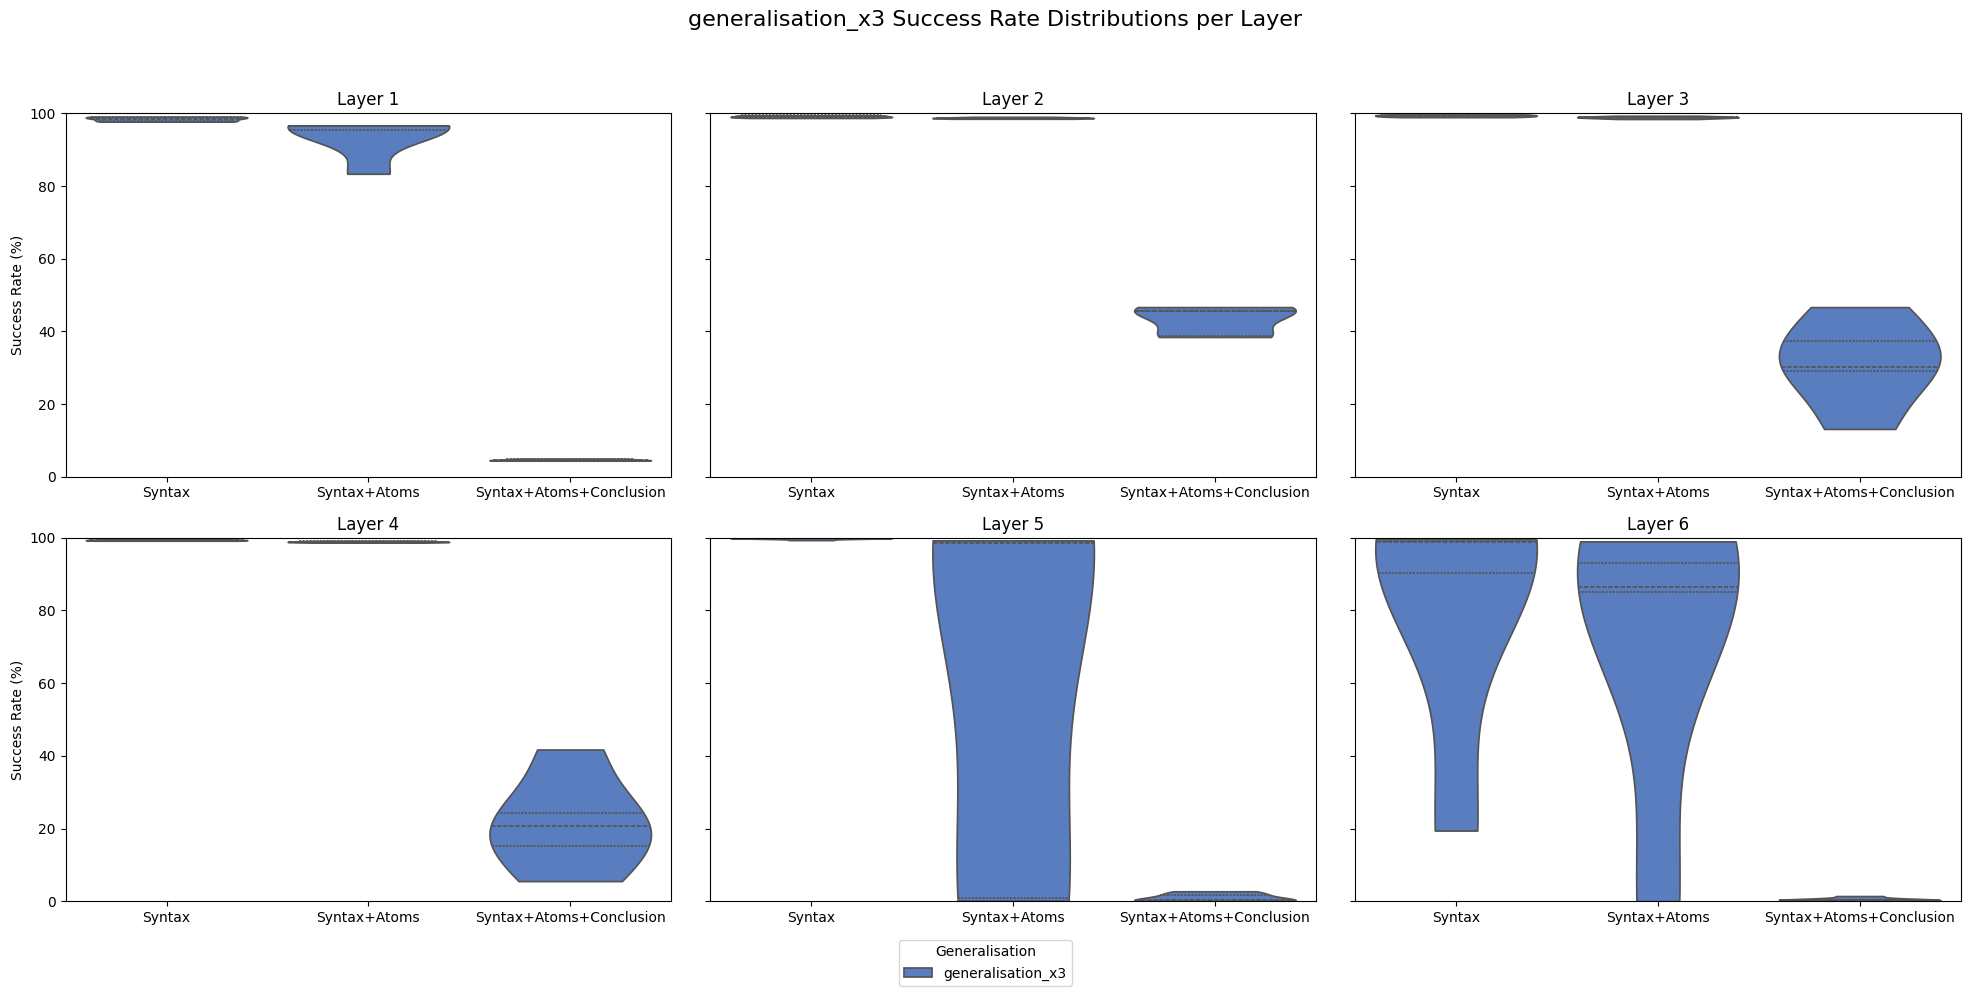

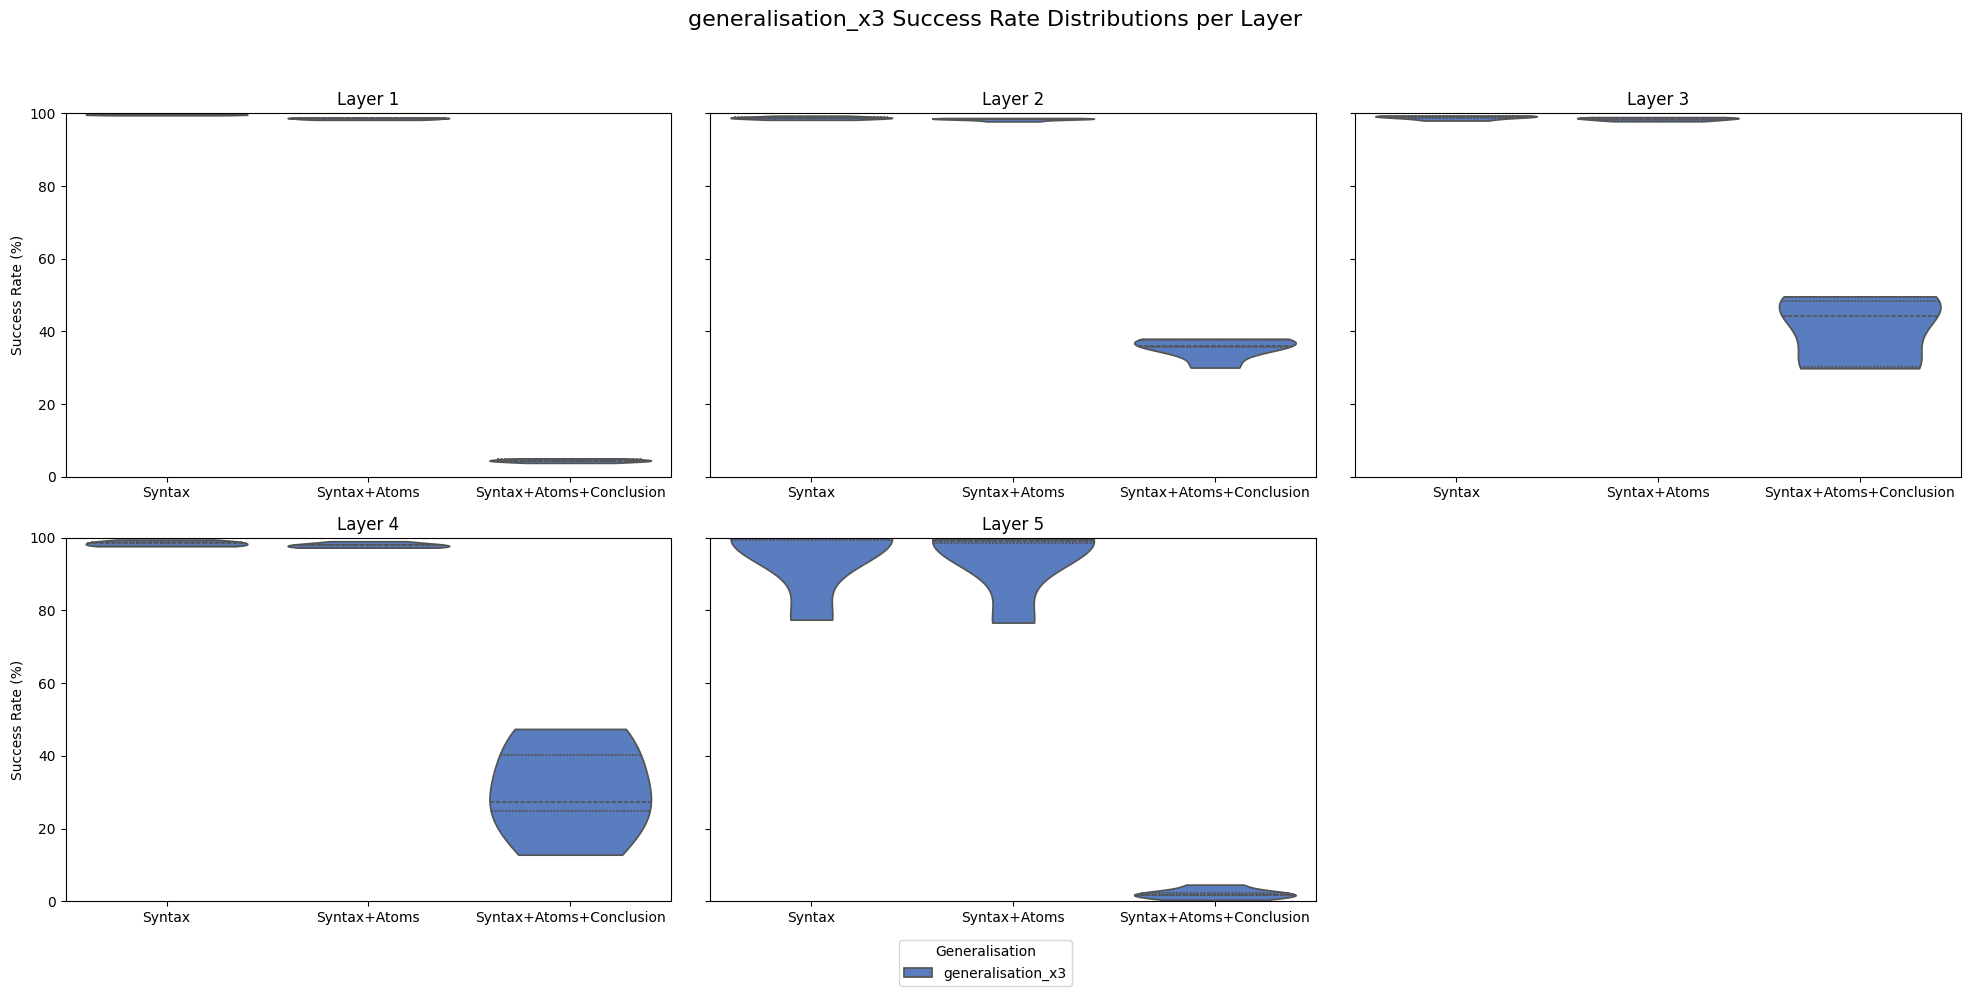

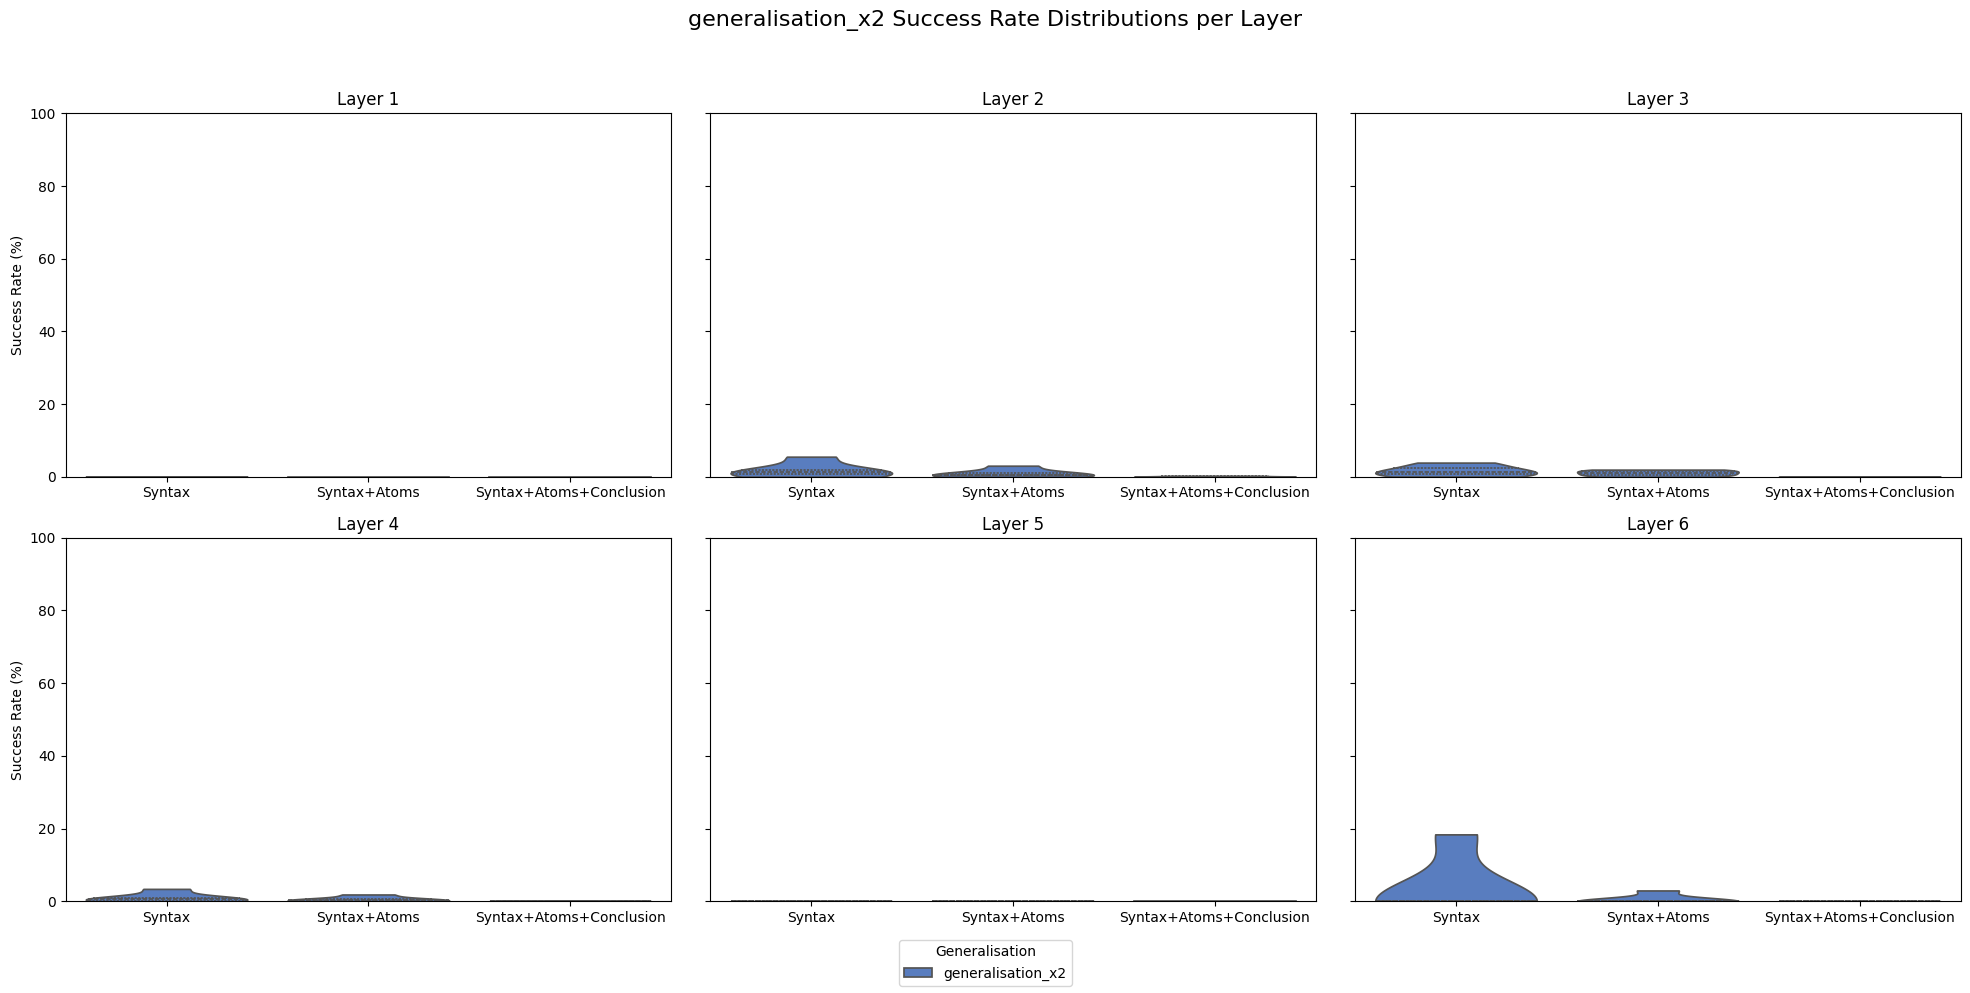

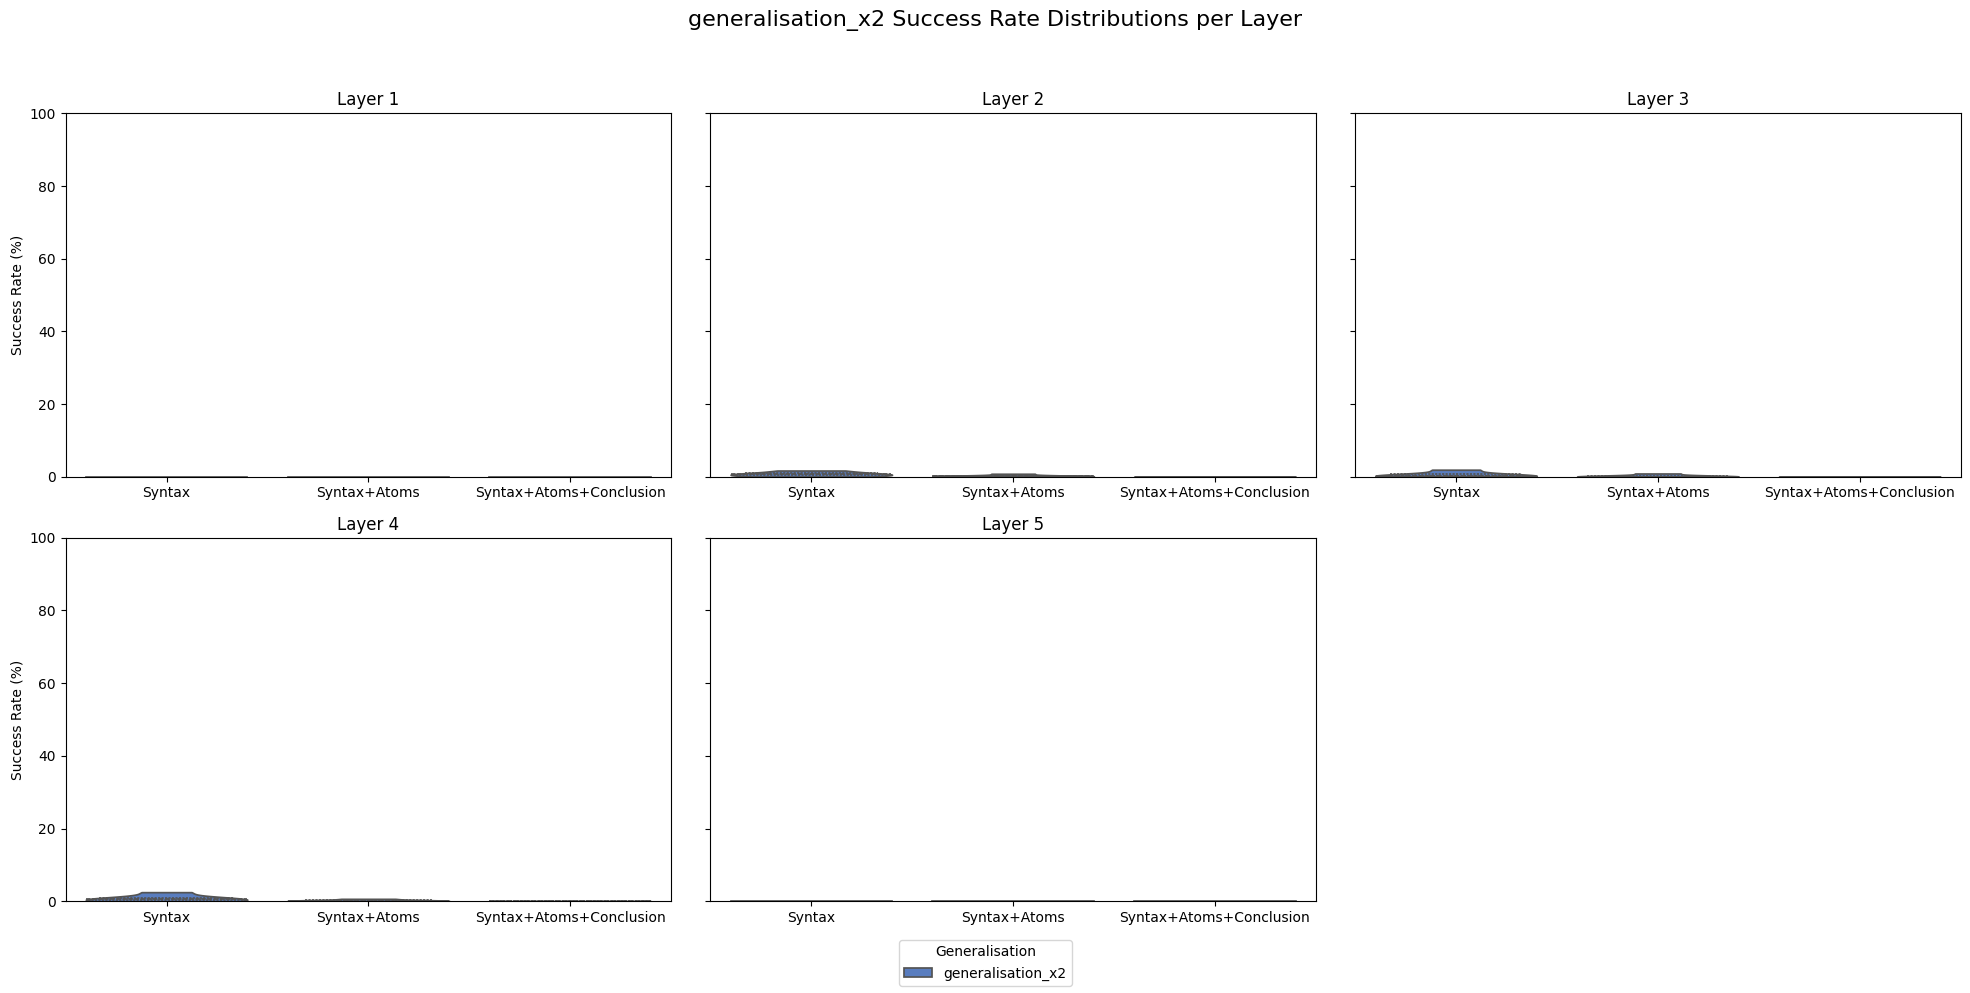

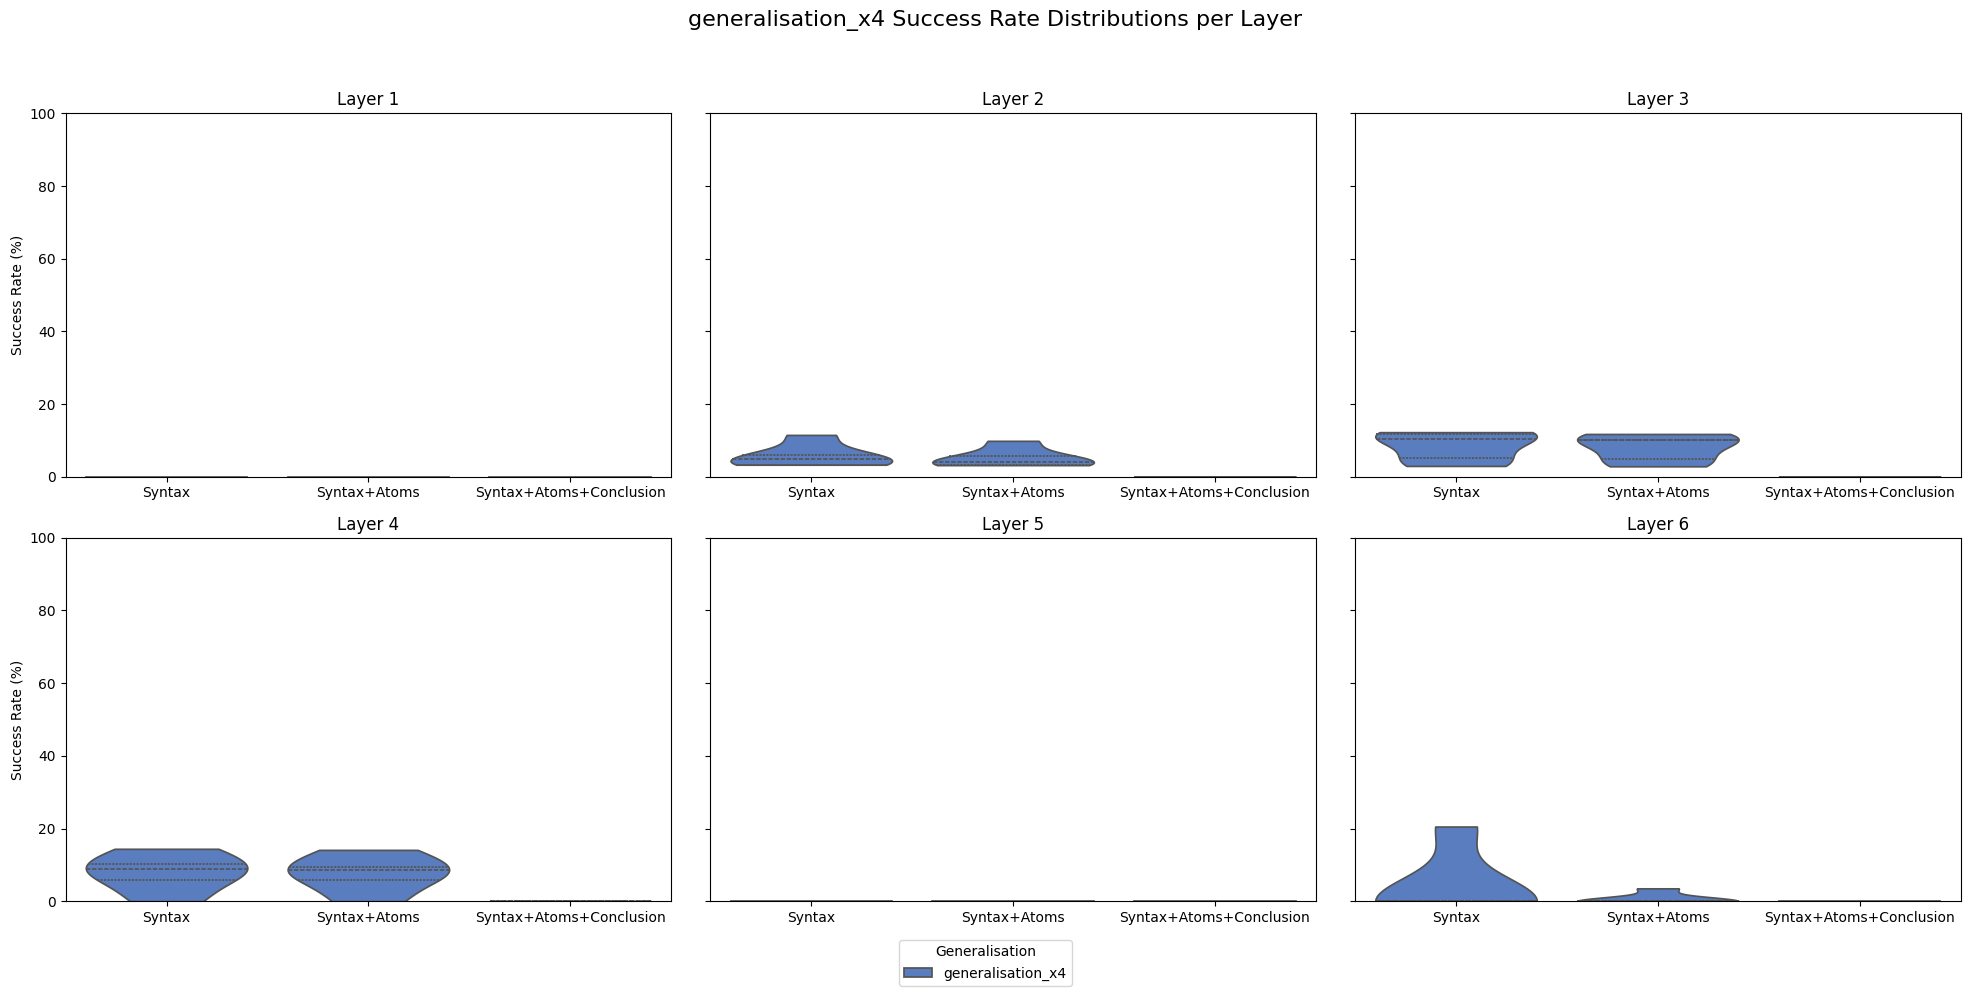

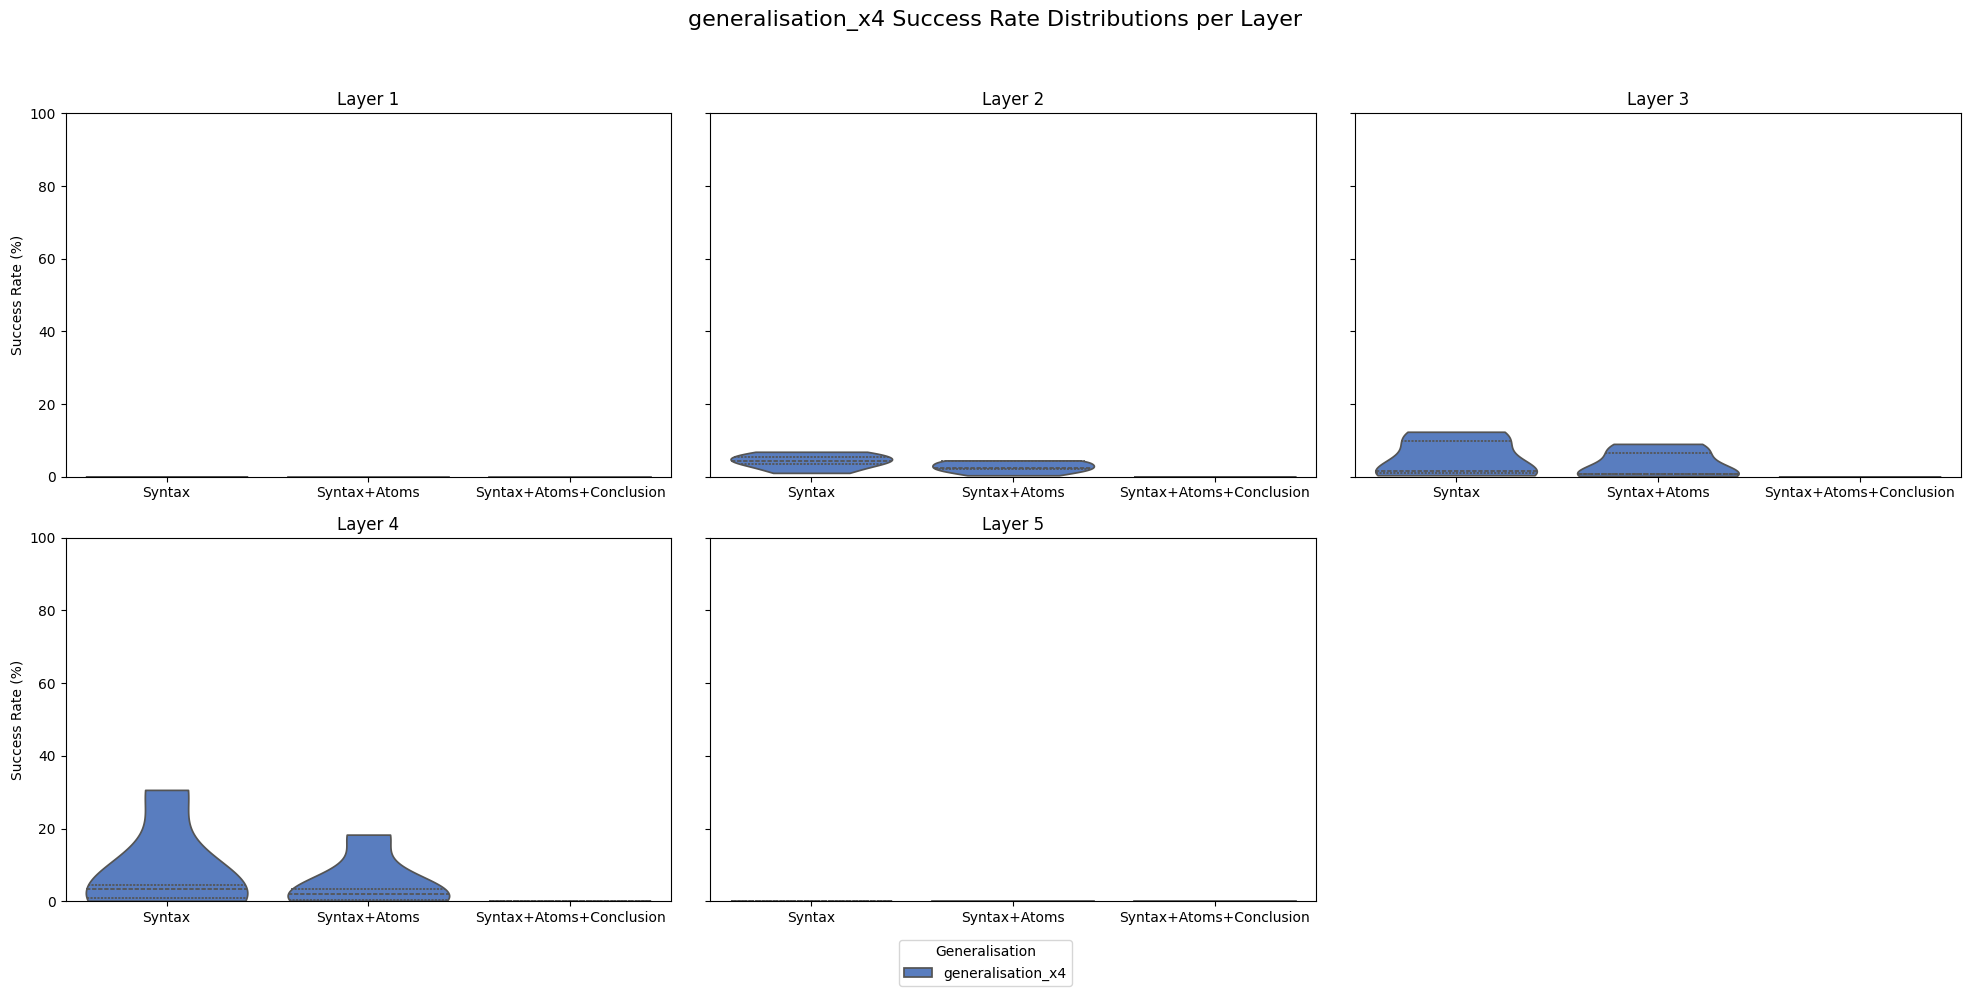

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_generalisation_violin(dataset, generalisation_cols=['generalisation_x2', 'generalisation_x3', 'generalisation_x4']):
    dataset = dataset.copy()
    dataset.reset_index(drop=True, inplace=True)

    records = []

    # Flatten all generalisation data into one tidy dataframe
    for generalisation_col in generalisation_cols:
        for i, row in dataset.iterrows():
            try:
                values = eval(row[generalisation_col])  # safely parse string to list
            except:
                continue  # skip if can't parse
            for version in range(3):  # 0: syntax, 1: +atoms, 2: +conclusion
                records.append({
                    'Layer': row['layers'],
                    'Attempt': row['atempt'],
                    'SuccessRate': values[version] * 100,
                    'Metric': ['Syntax', 'Syntax+Atoms', 'Syntax+Atoms+Conclusion'][version],
                    'Generalisation': generalisation_col
                })

    df = pd.DataFrame(records)

    unique_layers = sorted(df['Layer'].unique())
    num_layers = len(unique_layers)
    
    fig, axes = plt.subplots(2,3, figsize=(20, 10), sharey=True)
    axes = axes.flatten()

    for idx, layer in enumerate(unique_layers):
        ax = axes[idx]
        layer_df = df[df['Layer'] == layer]
        sns.violinplot(
            data=layer_df,
            x='Metric',
            y='SuccessRate',
            hue='Generalisation',
            ax=ax,
            inner='quart',
            cut=0,
            scale='width',
            palette='muted'
        )
        ax.set_title(f'Layer {layer}')
        ax.set_ylim(0, 100)
        ax.set_xlabel('')
        ax.set_ylabel('Success Rate (%)')
        ax.legend_.remove()

    # Remove unused axes
    for idx in range(len(unique_layers), len(axes)):
        fig.delaxes(axes[idx])

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(generalisation_cols), title='Generalisation')
    fig.suptitle(f'{generalisation_cols[0]} Success Rate Distributions per Layer', fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
plot_generalisation_violin(dataset, generalisation_cols=['generalisation_x3'])
plot_generalisation_violin(dataset_run2, generalisation_cols=['generalisation_x3'])
plot_generalisation_violin(dataset, generalisation_cols=['generalisation_x2'])
plot_generalisation_violin(dataset_run2, generalisation_cols=['generalisation_x2'])
plot_generalisation_violin(dataset, generalisation_cols=['generalisation_x4'])
plot_generalisation_violin(dataset_run2, generalisation_cols=['generalisation_x4'])

